# **Predicting the 2024 US Presidential Elections**

We'll analyze polling trends from past election cycles, incorporate additional features to capture recent dynamics, and explore different machine learning models to predict state-by-state outcomes.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import accumulate
from sklearn.linear_model import LogisticRegression

# Data Acquisition: FiveThirtyEight and Federal Election Commission

We start by loading polling data for the years 2024, 2020, and earlier cycles from CSV files. For 2024, we restrict the data to polls from the current election cycle. We then merge the historical data from 2016 and prior years with the 2020 data. In the resulting DataFrames, polls_24 and polls_until_20, we ensure consistency by converting date columns to datetime format and retaining key columns such as cycle, state, candidate name, and polling estimates.

In [2]:
polls_24=pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/Seajal9QNMDlBKfzc5Kpaw/presidential-general-averages.csv')
polls_20=pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/knh9Y6QVeSDqFb2dZejjdA/presidential-poll-averages-2020.csv')
polls_until_16=pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/cVut-n5JrpJcrXKX9A7jIA/pres-pollaverages-1968-2016.csv')

In [3]:
polls_24.head()

,candidate,date,pct_trend_adjusted,state,cycle,party,pct_estimate,hi,lo
0,Joseph R. Biden Jr.,2020-11-03,37.82732,Alabama,2020,NaN,NaN,NaN,NaN
1,Donald Trump,2020-11-03,57.36126,Alabama,2020,NaN,NaN,NaN,NaN
2,Joseph R. Biden Jr.,2020-11-02,37.82732,Alabama,2020,NaN,NaN,NaN,NaN
3,Donald Trump,2020-11-02,57.36126,Alabama,2020,NaN,NaN,NaN,NaN
4,Joseph R. Biden Jr.,2020-11-01,38.07011,Alabama,2020,NaN,NaN,NaN,NaN


In [4]:
polls_20.head()

,cycle,state,modeldate,candidate_name,pct_estimate,pct_trend_adjusted
0,2020,Wyoming,11/3/2020,Joseph R. Biden Jr.,30.81486,30.82599
1,2020,Wisconsin,11/3/2020,Joseph R. Biden Jr.,52.12642,52.09584
2,2020,West Virginia,11/3/2020,Joseph R. Biden Jr.,33.49125,33.51517
3,2020,Washington,11/3/2020,Joseph R. Biden Jr.,59.34201,59.39408
4,2020,Virginia,11/3/2020,Joseph R. Biden Jr.,53.74120,53.72101


In [5]:
polls_until_16.head()

,cycle,state,modeldate,candidate_name,candidate_id,pct_estimate,pct_trend_adjusted,timestamp,comment,election_date,...,_defaultbasetime,_numloops,_state_houseeffects_weight,_state_trendline_weight,_out_of_state_house_discount,_house_effects_multiplier,_attenuate_endpoints,_nonlinear_polynomial_degree,_shortpoly_combpoly_weight,_nat_shortpoly_combpoly_weight
0,2016,Alabama,3/3/2016,Donald Trump,9849,70.11138,68.63747,18:51:39 14 Jun 2020,full archive 1968-2016,11/8/2016,...,20,5,0.5,0.5,0.02,1,yes,2,0.8,0.5
1,2016,Alaska,3/3/2016,Donald Trump,9849,51.63014,49.68174,18:51:39 14 Jun 2020,full archive 1968-2016,11/8/2016,...,20,5,0.5,0.5,0.02,1,yes,2,0.8,0.5
2,2016,Arizona,3/3/2016,Donald Trump,9849,44.00000,41.02212,18:51:39 14 Jun 2020,full archive 1968-2016,11/8/2016,...,20,5,0.5,0.5,0.02,1,yes,2,0.8,0.5
3,2016,Colorado,3/3/2016,Donald Trump,9849,45.95150,43.51193,18:51:39 14 Jun 2020,full archive 1968-2016,11/8/2016,...,20,5,0.5,0.5,0.02,1,yes,2,0.8,0.5
4,2016,Florida,3/3/2016,Donald Trump,9849,46.54603,44.68674,18:51:39 14 Jun 2020,full archive 1968-2016,11/8/2016,...,20,5,0.5,0.5,0.02,1,yes,2,0.8,0.5


In [6]:
#Filtering and concating the df
polls_24=polls_24[polls_24['cycle']==2024]
polls_until_20=pd.concat([polls_20,polls_until_16],ignore_index=True)

In [7]:
# Making sure dates are in datetime format
polls_24['date']=pd.to_datetime(polls_24['date'], format='%Y-%m-%d')
polls_until_20['modeldate']=pd.to_datetime(polls_until_20['modeldate'])

In [8]:
# Keeping only the columns of interest
polls_until_20 = polls_until_20[['cycle', 'state', 'modeldate', 'candidate_name', 'pct_estimate', 'pct_trend_adjusted']]

The features for the 2024 dataset, `polls_24`, are shown here. Our primary focus is on polling data, which represents sampled opinions from the public to help predict the likely winner of the election.
<table>
  <thead>
    <tr>
      <th>Feature</th>
      <th>Description</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td><b>candidate</b></td>
      <td>The name of the candidate being polled, such as "Trump" or "Harris".</td>
    </tr>
    <tr>
      <td><b>date</b></td>
      <td>The date of the poll, formatted as YYYY-MM-DD, indicating when the poll was conducted.</td>
    </tr>
    <tr>
      <td><b>pct_trend_adjusted</b></td>
      <td>A trend-adjusted percentage, which takes into account historical data and trends to smooth fluctuations. (May contain NaN values if unavailable)</td>
    </tr>
    <tr>
      <td><b>state</b></td>
      <td>The U.S. state where the poll was conducted, such as "Arizona".</td>
    </tr>
    <tr>
      <td><b>cycle</b></td>
      <td>The election cycle year, indicating the relevant election year, such as 2024.</td>
    </tr>
    <tr>
      <td><b>party</b></td>
      <td>The political party of the candidate, typically "REP" (Republican), "DEM" (Democrat), or "IND" (Independent).</td>
    </tr>
    <tr>
      <td><b>pct_estimate</b></td>
      <td>The estimated vote share percentage for each candidate, based on the poll results.</td>
    </tr>
    <tr>
      <td><b>hi</b></td>
      <td>The upper bound of the vote share estimate, representing a higher confidence level in the candidate’s predicted support.</td>
    </tr>
    <tr>
      <td><b>lo</b></td>
      <td>The lower bound of the vote share estimate, representing a lower confidence level in the candidate’s predicted support.</td>
    </tr>
  </tbody>
</table>


In [9]:
# Importing result data
results_until_20 = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/tZjlzxTlT0mhKo_zs82e_w/results.csv', sep=';')
results_until_20 = results_until_20[['cycle', 'state', 'party', 'candidate', 'vote_share']]
results_until_20.head()

,cycle,state,party,candidate,vote_share
0,2012,Alabama,DEM,Barack Obama,"38,3590331"
1,2012,Alaska,DEM,Barack Obama,"40,81265911"
2,2012,Arizona,DEM,Barack Obama,"44,58976694"
3,2012,Arkansas,DEM,Barack Obama,"36,8789903"
4,2012,California,DEM,Barack Obama,"60,23895914"


In [10]:
#Implementing cycle restriction
start_cycle=2000
print("Length before the cycle",polls_until_20.shape)
polls_until_20=polls_until_20[polls_until_20['cycle']>=start_cycle]
print("Length before the cycle",polls_until_20.shape)

Length before the cycle (246558, 6)
Length before the cycle (153249, 6)


Let's filter out the swing states.

In [11]:
swing_states=['Pennsylvania', 'Wisconsin', 'Michigan', 'Georgia', 'North Carolina', 'Arizona', 'Nevada']
blue_states=['District of Columbia', 'Vermont', 'Massachusetts', 'Maryland', 'Hawaii', 'California', 'ME-1', 'Connecticut', 'Washington', 'Delaware', 'Rhode Island', 'New York', 'Illinois', 'New Jersey', 'Oregon', 'Colorado', 'Maine', 'New Mexico', 'Virginia', 'New Hampshire', 'NE-2', 'Minnesota']
red_states= ['Wyoming', 'West Virginia', 'Oklahoma', 'North Dakota', 'Idaho', 'South Dakota', 'Arkansas', 'Kentucky', 'NE-3', 'Alabama', 'Tennessee', 'Utah', 'Louisiana', 'Nebraska', 'Mississippi', 'Montana', 'NE-1', 'Indiana', 'Kansas', 'Missouri', 'South Carolina', 'Alaska', 'Ohio', 'Iowa', 'Texas', 'ME-2', 'Florida']

In [12]:
# Defining swing state subset of the poll data
swing_until_20=polls_until_20[polls_until_20['state'].isin(swing_states)]
swing_24=polls_24[polls_24['state'].isin(swing_states)]

In [13]:
swing_until_20.shape

(23712, 6)

In [14]:
swing_until_20.head()

,cycle,state,modeldate,candidate_name,pct_estimate,pct_trend_adjusted
1,2020,Wisconsin,2020-11-03,Joseph R. Biden Jr.,52.12642,52.09584
12,2020,Pennsylvania,2020-11-03,Joseph R. Biden Jr.,50.22000,50.20422
17,2020,North Carolina,2020-11-03,Joseph R. Biden Jr.,48.90633,48.90359
22,2020,Nevada,2020-11-03,Joseph R. Biden Jr.,49.62386,49.65657
31,2020,Michigan,2020-11-03,Joseph R. Biden Jr.,51.17806,51.15482


In [15]:
swing_24.shape

(4394, 9)

In [16]:
swing_24.head()

,candidate,date,pct_trend_adjusted,state,cycle,party,pct_estimate,hi,lo
21300,Trump,2024-10-29,NaN,Arizona,2024,REP,48.69350,50.002575,47.253310
21301,Harris,2024-10-29,NaN,Arizona,2024,DEM,46.83210,48.221905,45.462875
21302,Trump,2024-10-28,NaN,Arizona,2024,REP,48.67395,49.998210,47.306692
21303,Harris,2024-10-28,NaN,Arizona,2024,DEM,46.77425,48.183605,45.402925
21304,Trump,2024-10-27,NaN,Arizona,2024,REP,48.68695,50.014985,47.302782


In [17]:
swing_until_20.dtypes

,0
cycle,int64
state,object
modeldate,datetime64[ns]
candidate_name,object
pct_estimate,float64
pct_trend_adjusted,float64


To better understand the data, let's look at Trump’s chances in the 2020 election for example. This code filters the dataset to focus specifically on his polling estimates in Pennsylvania. It then creates a time series plot where the x-axis (modeldate) shows dates over this period, and the y-axis represents two lines: pct_estimate (Trump’s raw estimated support percentage) and pct_trend_adjusted (the trend-adjusted estimate that smooths fluctuations). This visualization helps us see both the immediate polling estimates and the overall trend in Trump’s predicted support in Pennsylvania as the election approached.

<function matplotlib.pyplot.show(close=None, block=None)>

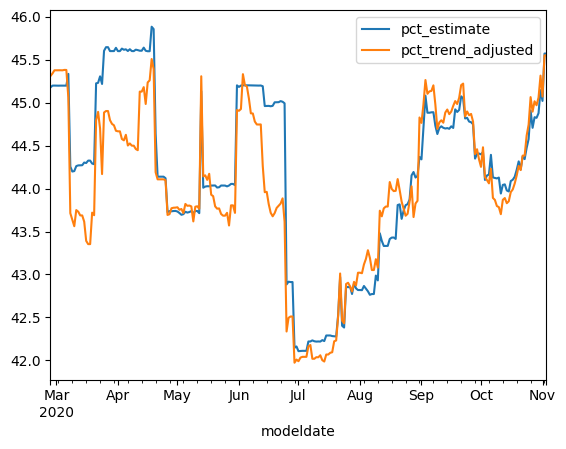

In [18]:
swing_until_20[(swing_until_20['state']=="Pennsylvania") &
               (swing_until_20['candidate_name']=='Donald Trump') &
               (swing_until_20['cycle']==2020)].plot(x='modeldate',y=['pct_estimate','pct_trend_adjusted']  )

plt.show

# Exploratory Data Analysis and Data Cleaning

In [19]:
# Checking for missing values in swing_24 and swing_until_20
print("Missing values in 2024 data:")
print(swing_24.isnull().sum())
print("\nMissing values in historical data:")
print(swing_until_20.isnull().sum())

Missing values in 2024 data:
candidate                0
date                     0
pct_trend_adjusted    4394
state                    0
cycle                    0
party                    0
pct_estimate             0
hi                       0
lo                       0
dtype: int64

Missing values in historical data:
cycle                 0
state                 0
modeldate             0
candidate_name        0
pct_estimate          0
pct_trend_adjusted    0
dtype: int64


In [20]:
#Check Basic stat
print("\nBasic Statistics for 2024 Data:")
print(swing_24.describe)
print("\nBasic Statistics for 2020 Data:")
print(swing_until_20.describe)


Basic Statistics for 2024 Data:
<bound method NDFrame.describe of       candidate       date  pct_trend_adjusted      state  cycle party  \
21300     Trump 2024-10-29                 NaN    Arizona   2024   REP   
21301    Harris 2024-10-29                 NaN    Arizona   2024   DEM   
21302     Trump 2024-10-28                 NaN    Arizona   2024   REP   
21303    Harris 2024-10-28                 NaN    Arizona   2024   DEM   
21304     Trump 2024-10-27                 NaN    Arizona   2024   REP   
...         ...        ...                 ...        ...    ...   ...   
29076   Kennedy 2024-03-02                 NaN  Wisconsin   2024   IND   
29077     Biden 2024-03-02                 NaN  Wisconsin   2024   DEM   
29078     Trump 2024-03-01                 NaN  Wisconsin   2024   REP   
29079   Kennedy 2024-03-01                 NaN  Wisconsin   2024   IND   
29080     Biden 2024-03-01                 NaN  Wisconsin   2024   DEM   

       pct_estimate         hi         lo  


Next, let’s check for the distinct values of each of our categorical variables.

In [21]:
# Checking distinct values for categorical variables
print("\n 2024 Data overview")
print(f"Earliest Polling Date:{swing_24['date'].min()}")
print(f"Latest Polling Date:{swing_24['date'].max()}")
print(f"Distinct States: {swing_24['state'].unique().tolist()}")
print(f"Distinct Parties: {swing_24['party'].unique().tolist()}")
print(f"Distinct Candidates: {swing_24['candidate'].unique().tolist()}")


 2024 Data overview
Earliest Polling Date:2024-03-01 00:00:00
Latest Polling Date:2024-10-29 00:00:00
Distinct States: ['Arizona', 'Georgia', 'Michigan', 'Nevada', 'North Carolina', 'Pennsylvania', 'Wisconsin']
Distinct Parties: ['REP', 'DEM', 'IND']
Distinct Candidates: ['Trump', 'Harris', 'Kennedy', 'Biden']


In [22]:
print("\nHistorical Data Overview:")
print(f"Earliest Polling Date: {swing_until_20['modeldate'].min()}")
print(f"Latest Polling Date: {swing_until_20['modeldate'].max()}")
print(f"Distinct States: {swing_until_20['state'].unique().tolist()}")
print(f"Distinct Candidates: {swing_until_20['candidate_name'].unique().tolist()}")


Historical Data Overview:
Earliest Polling Date: 2000-03-02 00:00:00
Latest Polling Date: 2020-11-03 00:00:00
Distinct States: ['Wisconsin', 'Pennsylvania', 'North Carolina', 'Nevada', 'Michigan', 'Georgia', 'Arizona']
Distinct Candidates: ['Joseph R. Biden Jr.', 'Donald Trump', 'Convention Bounce for Joseph R. Biden Jr.', 'Convention Bounce for Donald Trump', 'Hillary Rodham Clinton', 'Gary Johnson', 'Barack Obama', 'Mitt Romney', 'John McCain', 'George W. Bush', 'John Kerry', 'Al Gore', 'Ralph Nader']


In [23]:
# Removing 'Convention Bounce' observations from historical data
print("Data before we remove the convention bounce",swing_until_20.shape)
swing_until_20=swing_until_20[~swing_until_20['candidate_name'].str.startswith('Convention Bounce')]
print("Data after we remove the convention bounce",swing_until_20.shape)

Data before we remove the convention bounce (23712, 6)
Data after we remove the convention bounce (22683, 6)


We also perform some visualizations to get a clearer picture of the distribution of polls by state and candidate.

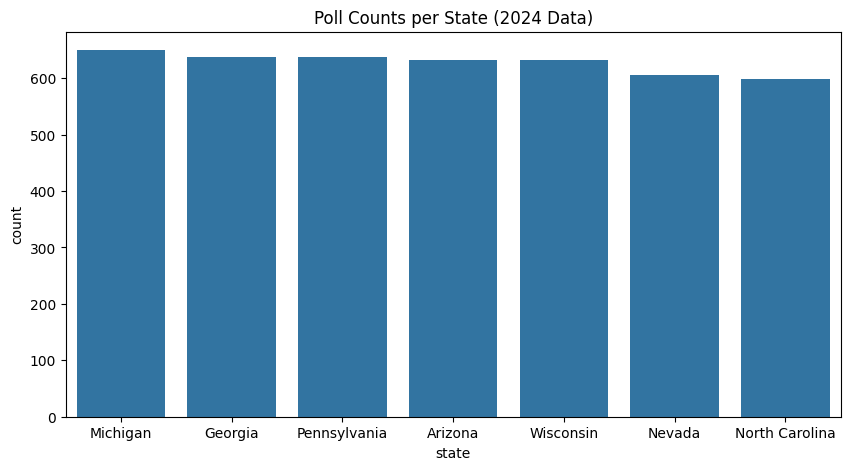

In [24]:
plt.figure(figsize=(10,5))
sns.countplot(x='state',data=swing_24,order=swing_24['state'].value_counts().index)
plt.title("Poll Counts per State (2024 Data)")
plt.show()

The plot shows the number of poll observations collected for each swing state in the 2024 dataset. Each bar represents a different state, and the length of the bar corresponds to the total number of polls conducted in that state.

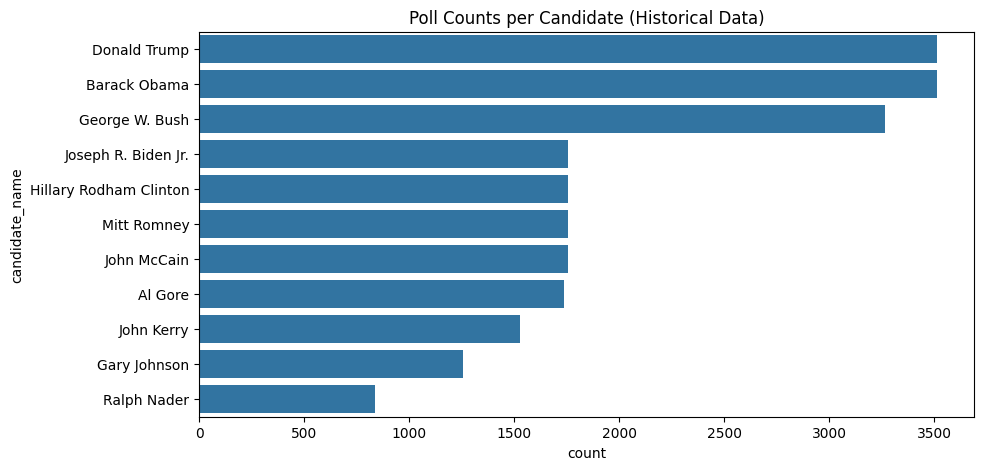

In [25]:
plt.figure(figsize=(10,5))
sns.countplot(y='candidate_name',data=swing_until_20,order=swing_until_20['candidate_name'].value_counts().index)
plt.title("Poll Counts per Candidate (Historical Data)")
plt.show()

This plot provides a historical perspective, showing which candidates have been frequently polled in past election cycles. It can highlight major figures from previous elections and help identify trends in polling focus over time.

# Estimated vs. trend-adjusted percentage

In [26]:
# Checking the correlation between the percentages
corr_swing=swing_until_20['pct_estimate'].corr(swing_until_20['pct_trend_adjusted'])
print('Correlation between estimated and trend-adjusted percentage in swing states:'+str(corr_swing))

# Calculate the mean difference between pct_estimate and pct_trend_adjusted
mean_diff=(swing_until_20['pct_estimate']-swing_until_20['pct_trend_adjusted']).mean()
print("Mean difference between estimated and trend-adjusted percentage in swing states:"+str(mean_diff))

Correlation between estimated and trend-adjusted percentage in swing states:0.9953626583357665
Mean difference between estimated and trend-adjusted percentage in swing states:0.24980898513865013


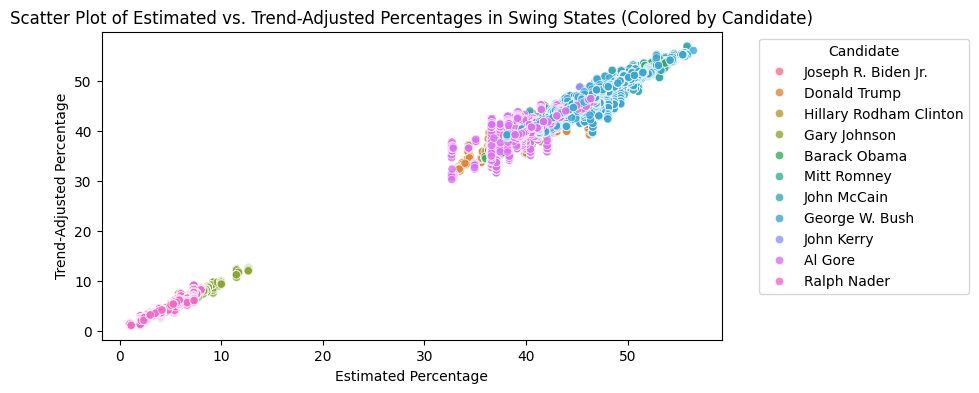

In [27]:
# Visualizing the correlation with different colors for each candidate
plt.figure(figsize=(8, 4))
sns.scatterplot(
    x='pct_estimate',
    y='pct_trend_adjusted',
    data=swing_until_20,
    hue='candidate_name',
    alpha=0.8
)
plt.title('Scatter Plot of Estimated vs. Trend-Adjusted Percentages in Swing States (Colored by Candidate)')
plt.xlabel('Estimated Percentage')
plt.ylabel('Trend-Adjusted Percentage')
plt.legend(title='Candidate', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

The correlation between the estimated and trend-adjusted percentages is remarkably high at 99.5%, which is not surprising. However, despite the seemingly small average difference of around 0.25 percentage points, it could have significant implications in closely contested races, such as those anticipated in Nevada or Michigan.

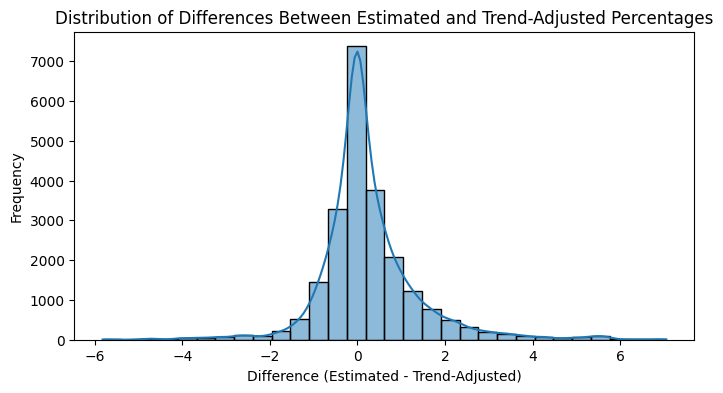

In [28]:
# Plotting the distribution of differences
swing_until_20['difference']=swing_until_20['pct_estimate']-swing_until_20['pct_trend_adjusted']
plt.figure(figsize=(8,4))
sns.histplot(swing_until_20['difference'],bins=30,kde=True)
plt.title('Distribution of Differences Between Estimated and Trend-Adjusted Percentages')
plt.xlabel('Difference (Estimated - Trend-Adjusted)')
plt.ylabel('Frequency')
plt.show()

# Adding party column and historical result data

To add a column for the political party, we start by extracting a list of all candidates from the historical dataset. Next, we create a dictionary mapping each candidate to their respective party. Finally, we convert this information into a DataFrame and merge it with swing_until_20.

In [29]:
# Get unique candidate name
candidate_name=swing_until_20['candidate_name'].unique().tolist()

In [30]:
# Create a party_map with checks for unmapped candidates
party_map = {
    'Joseph R. Biden Jr.': 'DEM',
    'Donald Trump': 'REP',
    'Hillary Rodham Clinton': 'DEM',
    'Gary Johnson': 'LIB',
    'Barack Obama': 'DEM',
    'Mitt Romney': 'REP',
    'John McCain': 'REP',
    'Ralph Nader': 'IND',
    'George W. Bush': 'REP',
    'John Kerry': 'DEM',
    'Al Gore': 'DEM'
}

In [31]:
# Add a default party for unmapped candidates
default_party = 'UNKNOWN'

In [32]:
# Create a DataFrame with candidates and their respective parties
candidate_df=pd.DataFrame(candidate_name,columns=['candidate_name'])
candidate_df['party']=candidate_df['candidate_name'].map(party_map).fillna(default_party)

In [33]:
candidate_df.head()

,candidate_name,party
0,Joseph R. Biden Jr.,DEM
1,Donald Trump,REP
2,Hillary Rodham Clinton,DEM
3,Gary Johnson,LIB
4,Barack Obama,DEM


In [34]:
# Log unmapped candidates for review
unmapped_candidates = candidate_df[candidate_df['party'] == default_party]['candidate_name'].tolist()
if unmapped_candidates:
    print("Unmapped candidates found:", unmapped_candidates)
else:
    print("No unmapped candidate found.")

No unmapped candidate found.


In [35]:
# Merge the candidate_df with swing_until_20 on 'candidate_name' column
swing_until_20=swing_until_20.merge(candidate_df[['candidate_name','party']],on='candidate_name',how='left')

In [36]:
# Merging results_until_20 to swing_until_20 with validation
swing_until_20=pd.merge(
    swing_until_20,
    results_until_20,
    how='left',
    left_on=['cycle','state','party', 'candidate_name'],
    right_on=['cycle', 'state', 'party', 'candidate']
)

In [37]:
# Convert vote_share to a numeric format, replacing commas with periods
swing_until_20['vote_share'] = swing_until_20['vote_share'].str.replace(',', '.')
swing_until_20['vote_share']=pd.to_numeric(swing_until_20['vote_share'],errors='coerce')

In [38]:
# Check for any missing vote_share values after the conversion
missing_vote_share=swing_until_20[swing_until_20['vote_share'].isna()]
if not missing_vote_share.empty:
   print("Rows with missing vote_share after conversion:\n", missing_vote_share)

Rows with missing vote_share after conversion:
        cycle           state  modeldate candidate_name  pct_estimate  \
3892    2016       Wisconsin 2016-03-30   Gary Johnson      9.198407   
3907    2016       Wisconsin 2016-03-31   Gary Johnson      9.198407   
3922    2016       Wisconsin 2016-04-01   Gary Johnson      9.198407   
3937    2016       Wisconsin 2016-04-02   Gary Johnson      9.198407   
3952    2016       Wisconsin 2016-04-03   Gary Johnson      9.198407   
...      ...             ...        ...            ...           ...   
22664   2000        Michigan 2000-11-07    Ralph Nader      3.512400   
22665   2000          Nevada 2000-11-07    Ralph Nader      3.011737   
22666   2000  North Carolina 2000-11-07    Ralph Nader      1.117046   
22667   2000    Pennsylvania 2000-11-07    Ralph Nader      4.144868   
22668   2000       Wisconsin 2000-11-07    Ralph Nader      5.263384   

       pct_trend_adjusted  difference party candidate  vote_share  
3892             9.

We also visualize the distribution of vote_share for all candidates combined. This helps us understand how vote shares are distributed across the entire dataset, showing the frequency of different vote share percentages and indicating any common patterns, such as whether most vote shares cluster around certain values.

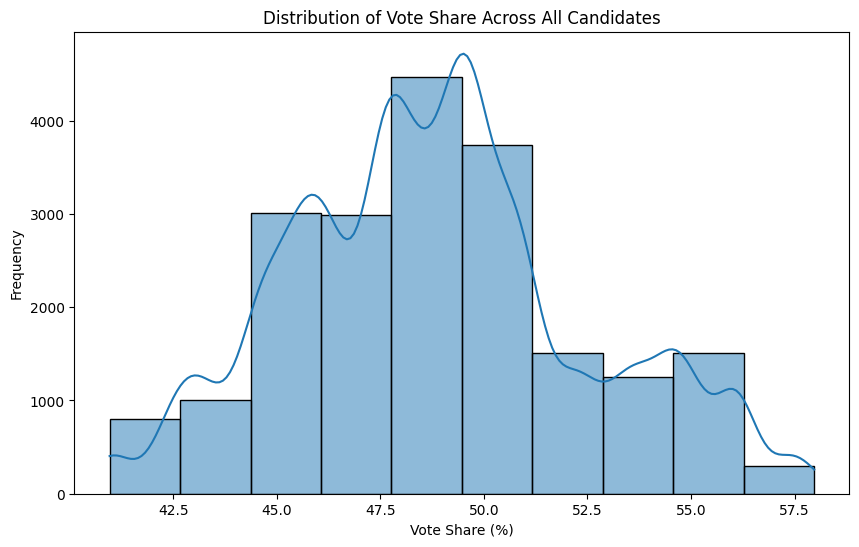

In [39]:
# Plot the distribution of vote_share for all data
plt.figure(figsize=(10, 6))
sns.histplot(swing_until_20['vote_share'], bins=10, kde=True)
plt.title('Distribution of Vote Share Across All Candidates')
plt.xlabel('Vote Share (%)')
plt.ylabel('Frequency')
plt.show()

Lastly, we use a box plot to display the distribution of vote_share for each individual candidate. This visualization highlights the median, interquartile range, and any outliers for each candidate’s vote share, allowing us to compare how different candidates performed.

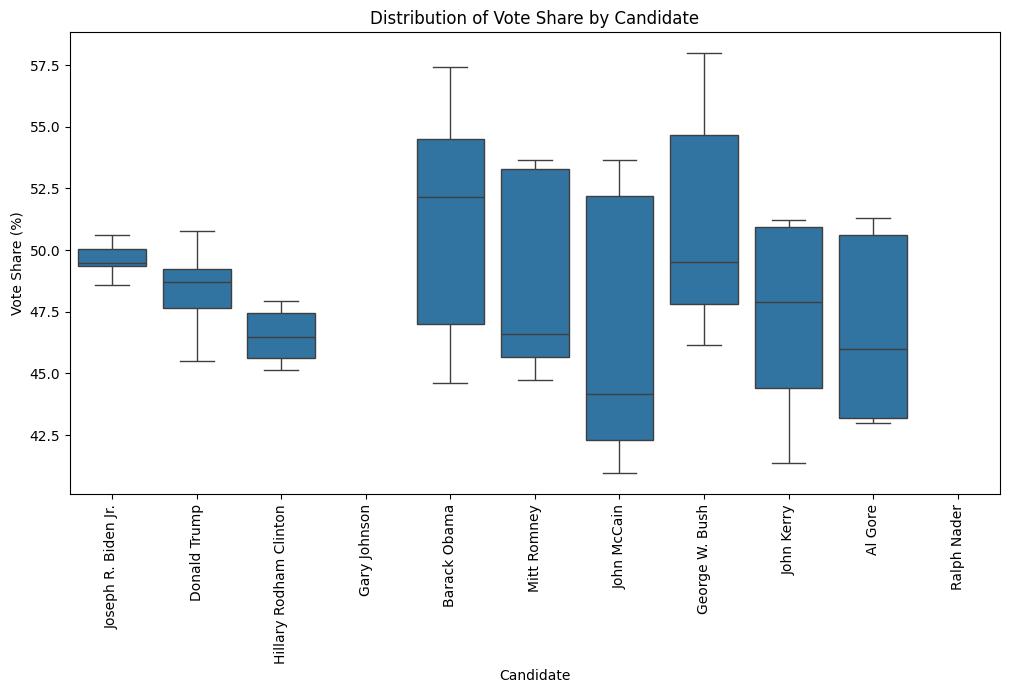

In [40]:
# Plot the distribution of vote_share by candidate
plt.figure(figsize=(12, 6))
sns.boxplot(x='candidate_name', y='vote_share', data=swing_until_20)
plt.title('Distribution of Vote Share by Candidate')
plt.xlabel('Candidate')
plt.ylabel('Vote Share (%)')
plt.xticks(rotation=90)
plt.show()

These visualizations provide insights into the overall distribution of vote shares, as well as how these distributions differ between individual candidates and political parties.

# Cleaning up columns

To wrap up the EDA, we rename the modeldate column to date, drop any unnecessary columns, and update the candidate format in the 2024 data to include first names.

In [41]:
# Renaming columns in swing_until_20
swing_until_20.rename(columns={'modeldate': 'date'}, inplace=True)

In [42]:
# Keeping only relevant columns
swing_24 = swing_24[['cycle', 'date', 'state', 'party', 'candidate', 'pct_estimate']]
swing_until_20 = swing_until_20[['cycle', 'date', 'state', 'party', 'candidate', 'pct_estimate', 'vote_share']]

In [43]:
# Update candidate names in swing_24 dataframe
swing_24['candidate'] = swing_24['candidate'].replace({
    'Trump': 'Donald Trump',
    'Biden': 'Joseph R. Biden Jr.',
    'Harris': 'Kamala Harris',
    'Kennedy': 'Robert F. Kennedy'})

<ipython-input-43-0ca5266dd069>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  swing_24['candidate'] = swing_24['candidate'].replace({


In [44]:
swing_24.head()

,cycle,date,state,party,candidate,pct_estimate
21300,2024,2024-10-29,Arizona,REP,Donald Trump,48.69350
21301,2024,2024-10-29,Arizona,DEM,Kamala Harris,46.83210
21302,2024,2024-10-28,Arizona,REP,Donald Trump,48.67395
21303,2024,2024-10-28,Arizona,DEM,Kamala Harris,46.77425
21304,2024,2024-10-27,Arizona,REP,Donald Trump,48.68695


# **2024 Campaign Overview**

# Overview by swing states

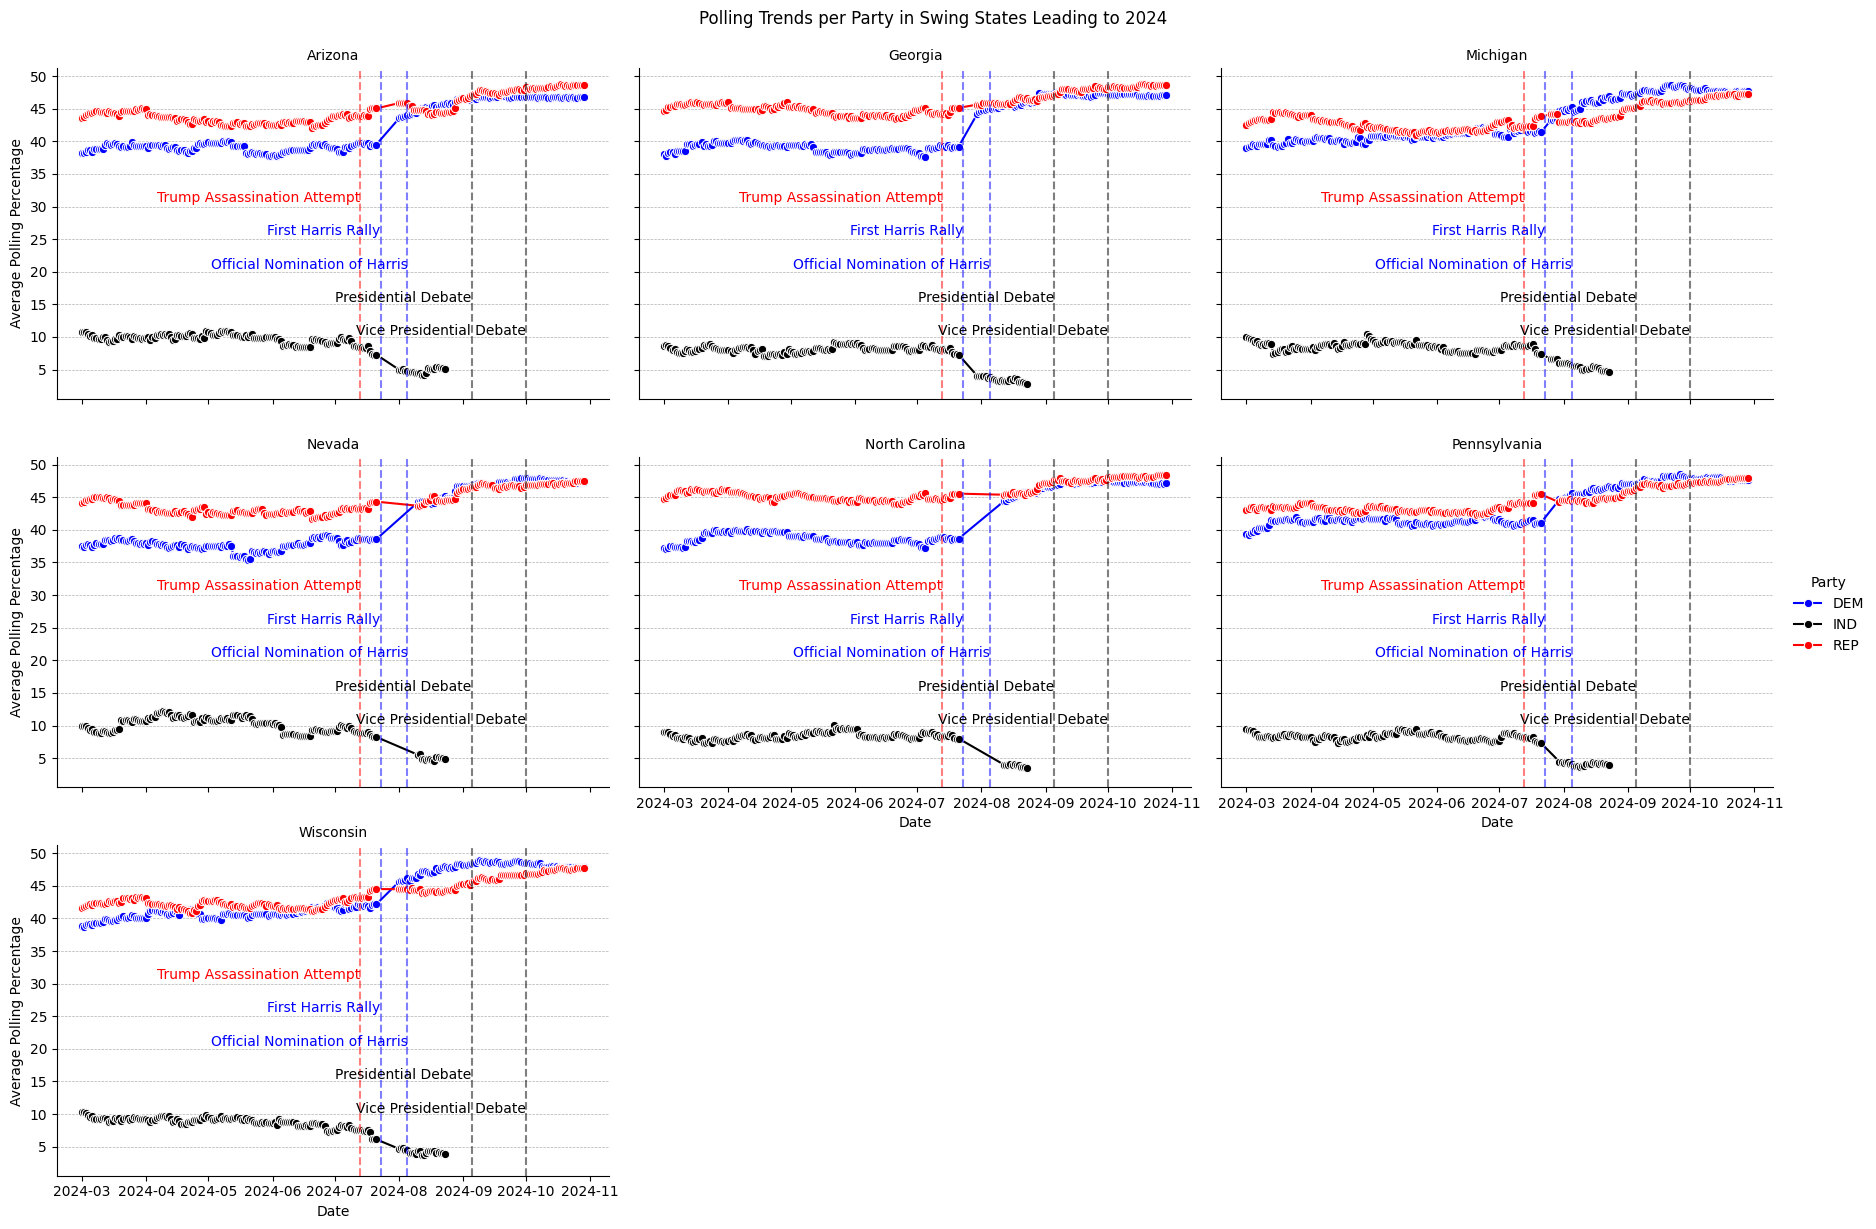

In [46]:
# Convert the date column to datetime format for accurate time series plotting
swing_24['date'] = pd.to_datetime(swing_24['date'])

# Aggregate data by date, state, and party to get average polling estimates
averaged_polling_data = swing_24.groupby(['date', 'state', 'party'])['pct_estimate'].mean().reset_index()

# Set up a grid of line plots for each state using seaborn's FacetGrid
facet = sns.FacetGrid(averaged_polling_data, col='state', col_wrap=3, height=4, aspect=1.5, sharey=True) # Changed average_polling to averaged_polling_data
facet.map_dataframe(sns.lineplot, x='date', y='pct_estimate', hue='party', marker='o',
                    palette={'REP': 'red', 'DEM': 'blue', 'IND': 'black'})

# Add significant event markers to each subplot
significant_dates = [
    ('2024-07-13', 'Trump Assassination Attempt', 'red', 0.6),
    ('2024-07-23', 'First Harris Rally', 'blue', 0.5),
    ('2024-08-05', 'Official Nomination of Harris', 'blue', 0.4),
    ('2024-09-05', 'Presidential Debate', 'black', 0.3),
    ('2024-10-01', 'Vice Presidential Debate', 'black', 0.2)
]

for ax in facet.axes.flat:
    for date, label, color, text_y_pos in significant_dates:
        ax.axvline(pd.to_datetime(date), color=color, linestyle='--', alpha=0.5)
        ax.text(pd.to_datetime(date), ax.get_ylim()[1] * text_y_pos, label, color=color, ha='right')
    ax.yaxis.set_major_locator(plt.MultipleLocator(5))
    ax.yaxis.grid(True, linestyle='--', linewidth=0.5)

# Add legend and set labels and titles
facet.add_legend(title='Party')
facet.set_titles("{col_name}")
facet.set_axis_labels("Date", "Average Polling Percentage")
facet.fig.suptitle('Polling Trends per Party in Swing States Leading to 2024', y=1.02)

plt.show()

## Overview across swing states


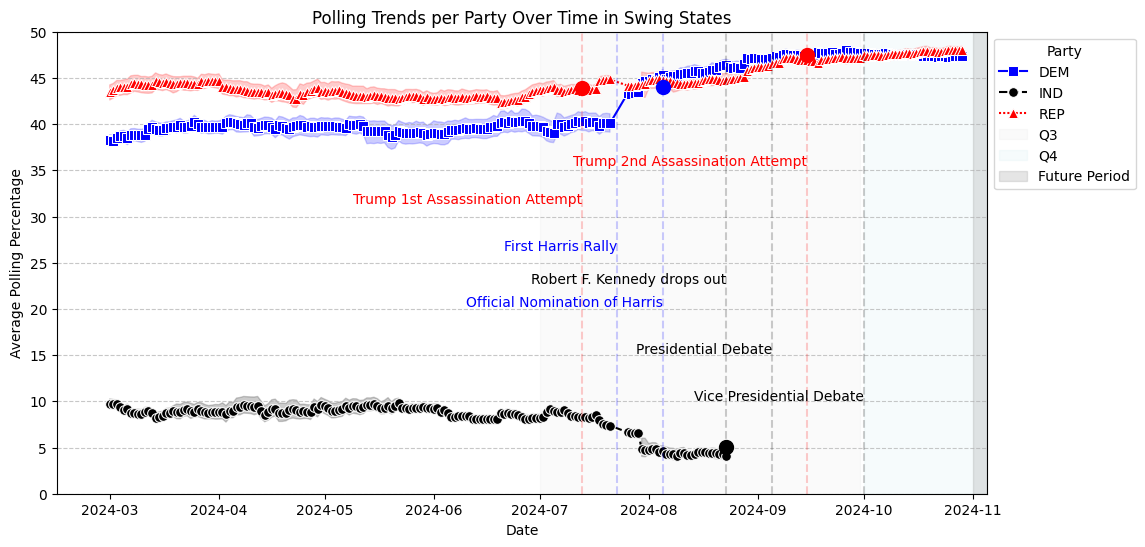

In [47]:
# Ensure 'date' column in the data is restricted to relevant period
start_date = '2024-02-15'
end_date = '2024-11-05'
averaged_polling_data = averaged_polling_data[(averaged_polling_data['date'] >= start_date) &
                                              (averaged_polling_data['date'] <= end_date)]

# Set up the plot
plt.figure(figsize=(12, 6))

# Define custom markers for each party and use larger markers for key dates
markers = {'REP': '^', 'DEM': 's', 'IND': 'o'}
sns.lineplot(
    x='date', y='pct_estimate', data=averaged_polling_data,
    hue='party', style='party', markers=markers, markersize=7,
    palette={'REP': 'red', 'DEM': 'blue', 'IND': 'black'}
)

# Mark key dates with larger markers for emphasis
event_dates = [
    ('2024-07-13', 'Trump 1st Assassination Attempt', 'red', 0.62, 'REP'),
    ('2024-07-23', 'First Harris Rally', 'blue', 0.52, 'DEM'),
    ('2024-08-05', 'Official Nomination of Harris', 'blue', 0.4, 'DEM'),
    ('2024-08-23', 'Robert F. Kennedy drops out', 'black', 0.45, 'IND'),
    ('2024-09-05', 'Presidential Debate', 'black', 0.3, 'IND'),
    ('2024-09-15', 'Trump 2nd Assassination Attempt', 'red', 0.7, 'REP'),
    ('2024-10-01', 'Vice Presidential Debate', 'black', 0.2, 'IND')
]

for date, label, color, text_y_pos, party in event_dates:
    plt.axvline(pd.to_datetime(date), color=color, linestyle='--', alpha=0.2)
    plt.text(pd.to_datetime(date), plt.ylim()[1] * text_y_pos, label, color=color, ha='right')

    # Plot large markers on event dates if data exists
    point_data = averaged_polling_data.loc[
        (averaged_polling_data['date'] == pd.to_datetime(date)) &
        (averaged_polling_data['party'] == party), 'pct_estimate'
    ]

    if not point_data.empty:
        plt.plot(pd.to_datetime(date), point_data.values[0], marker='o', markersize=10, color=color)

# Add background gradient for campaign phases or quarters
plt.axvspan(pd.to_datetime('2024-07-01'), pd.to_datetime('2024-09-30'), color='lightgray', alpha=0.1, label='Q3')
plt.axvspan(pd.to_datetime('2024-10-01'), pd.to_datetime('2024-12-31'), color='lightblue', alpha=0.1, label='Q4')

# Highlight current date and beyond with a shaded area
current_date = pd.to_datetime('2024-11-01')
plt.axvspan(current_date, pd.to_datetime(end_date), color='gray', alpha=0.2, label='Future Period')

# Limit x-axis to the year 2024
plt.xlim(pd.to_datetime(start_date), pd.to_datetime(end_date))

# Customize legend and add gridlines, labels, and titles
plt.legend(title='Party', loc='upper left', bbox_to_anchor=(1, 1))
plt.yticks(range(0, 51, 5))
plt.grid(visible=True, which='major', axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, 50)
plt.title('Polling Trends per Party Over Time in Swing States')
plt.xlabel('Date')
plt.ylabel('Average Polling Percentage')

# Display the plot
plt.show()


In [48]:
import plotly.express as px

# Create an interactive plot using Plotly with custom colors
fig = px.line(
    averaged_polling_data,
    x='date',
    y='pct_estimate',
    color='party',
    markers=True,
    title='Interactive Average Polling Percentage per Party Over Time in Swing States',
    color_discrete_map={'REP': 'red', 'DEM': 'blue', 'IND': 'black'}  # Custom colors
)

# Customize the layout
fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Average Polling Percentage',
    yaxis=dict(range=[0, 50])
)

# Show the interactive plot
fig.show()


Recent polling data for the 2024 presidential election indicates a highly competitive race across key swing states.

# **Feature Engineering**

We consider four main types of features to boost the model's predictive capabilities: opponent-based, temporal, candidate-specific, and party-focused features.

- **Opponent-Based Features**: These features capture the dynamics of the electoral competition, allowing the model to consider how rival candidates influence each other's support.
- **Temporal Features**: These features represent time-related patterns, including seasonality and shifts in voter sentiment as the election nears, which can be vital for understanding how opinions evolve.
- **Candidate-Specific Features**: These features incorporate information about the candidates themselves, such as their incumbency status or their public reputation, which can influence voter behavior.
- **Party-Focused Features**: These features reflect broader trends and associations linked to political parties, helping the model contextualize voter preferences and partisan loyalty.

# Opponent-Based Features

In [49]:
# Adding the percentage of 3rd party candidates
swing_24['pct_3rd_party'] = swing_24.groupby(['cycle', 'date', 'state'])['pct_estimate'].transform(
    lambda x: x[~swing_24['party'].isin(['DEM', 'REP'])].sum()
)
swing_until_20['pct_3rd_party'] = swing_until_20.groupby(['cycle', 'date', 'state'])['pct_estimate'].transform(
    lambda x: x[~swing_until_20['party'].isin(['DEM', 'REP'])].sum()
)

In [50]:
# Removing observations of candidates who are not Democrats and Republicans
swing_24 = swing_24[swing_24['party'].isin(['DEM', 'REP'])]
swing_until_20 = swing_until_20[swing_until_20['party'].isin(['DEM', 'REP'])]

In [51]:
# Calculate the total percentage estimate for each group of (date, state)
swing_24['total_pct_estimate'] = swing_24.groupby(['date', 'state'])['pct_estimate'].transform('sum')
swing_until_20['total_pct_estimate'] = swing_until_20.groupby(['date', 'state'])['pct_estimate'].transform('sum')

# Calculate the percentage of the opponent as the total minus the candidate's percentage
swing_24['pct_opponent'] = swing_24['total_pct_estimate'] - swing_24['pct_estimate']
swing_until_20['pct_opponent'] = swing_until_20['total_pct_estimate'] - swing_until_20['pct_estimate']

# Calculate the lead against the opponent
swing_24['lead'] = swing_24['pct_estimate'] - swing_24['pct_opponent']
swing_until_20['lead'] = swing_until_20['pct_estimate'] - swing_until_20['pct_opponent']

# Drop the temporary total_pct_estimate column as it's no longer needed
swing_24.drop(columns=['total_pct_estimate'], inplace=True)
swing_until_20.drop(columns=['total_pct_estimate'], inplace=True)

In [52]:
swing_24.head()

,cycle,date,state,party,candidate,pct_estimate,pct_3rd_party,pct_opponent,lead
21300,2024,2024-10-29,Arizona,REP,Donald Trump,48.69350,0.0,46.83210,1.8614
21301,2024,2024-10-29,Arizona,DEM,Kamala Harris,46.83210,0.0,48.69350,-1.8614
21302,2024,2024-10-28,Arizona,REP,Donald Trump,48.67395,0.0,46.77425,1.8997
21303,2024,2024-10-28,Arizona,DEM,Kamala Harris,46.77425,0.0,48.67395,-1.8997
21304,2024,2024-10-27,Arizona,REP,Donald Trump,48.68695,0.0,46.87025,1.8167


In [53]:
# Election dates dictionary
election_dates = {
    2000: pd.to_datetime('2000-11-07'),
    2004: pd.to_datetime('2004-11-02'),
    2008: pd.to_datetime('2008-11-04'),
    2012: pd.to_datetime('2012-11-06'),
    2016: pd.to_datetime('2016-11-08'),
    2020: pd.to_datetime('2020-11-03')
}

# Assign election dates
swing_until_20['election_date'] = swing_until_20['cycle'].map(election_dates)
swing_24['election_date'] = pd.to_datetime('2024-11-05')

# Calculate days until election
swing_24['days_until_election'] = (swing_24['election_date'] - swing_24['date']).dt.days
swing_until_20['days_until_election'] = (swing_until_20['election_date'] - swing_until_20['date']).dt.days

In [54]:
# Sorting by date to ensure correct calculation of rolling averages
swing_24 = swing_24.sort_values(by='date')
swing_until_20 = swing_until_20.sort_values(by='date')

# Rolling average (7-day window) to smooth out short-term fluctuations
swing_24['rolling_avg_7d'] = swing_24.groupby(['state', 'party'])['pct_estimate'].transform(
    lambda x: x.rolling(window=7, min_periods=1).mean()
)
swing_until_20['rolling_avg_7d'] = swing_until_20.groupby(['cycle', 'state', 'party'])['pct_estimate'].transform(
    lambda x: x.rolling(window=7, min_periods=1).mean()
)

# Exponential moving average (7-day span) to emphasize recent data
swing_24['exp_moving_avg_7d'] = swing_24.groupby(['state', 'party'])['pct_estimate'].transform(
    lambda x: x.ewm(span=7, adjust=False).mean()
)
swing_until_20['exp_moving_avg_7d'] = swing_until_20.groupby(['cycle', 'state', 'party'])['pct_estimate'].transform(
    lambda x: x.ewm(span=7, adjust=False).mean()
)

# Calculating momentum: daily change in poll estimates for each candidate
swing_24['momentum_candidate'] = swing_24.groupby(['state', 'party'])['pct_estimate'].diff()
swing_until_20['momentum_candidate'] = swing_until_20.groupby(['state', 'party'])['pct_estimate'].diff()

# Calculating momentum for the opponent
swing_24['momentum_opponent'] = swing_24.groupby(['state', 'party'])['pct_opponent'].diff()
swing_until_20['momentum_opponent'] = swing_until_20.groupby(['state', 'party'])['pct_opponent'].diff()

# Difference between candidate and opponent momentum
swing_24['momentum'] = swing_24['momentum_candidate'] - swing_24['momentum_opponent']
swing_until_20['momentum'] = swing_until_20['momentum_candidate'] - swing_until_20['momentum_opponent']

In [55]:
# Calculate the number of missing values in each column of swing_until_20
missing_values_until_20 = swing_until_20.isnull().sum()
missing_values_24 = swing_24.isnull().sum()

# Filter out columns that have no missing values
missing_values_until_20 = missing_values_until_20[missing_values_until_20 > 0]
missing_values_24 = missing_values_24[missing_values_24 > 0]

# Display the columns with at least 1 missing value and their respective counts for both dataframes
print(missing_values_until_20, missing_values_24)

momentum_candidate    14
momentum_opponent     14
momentum              14
dtype: int64 momentum_candidate    14
momentum_opponent     14
momentum              14
dtype: int64


In [56]:
swing_24.head()

,cycle,date,state,party,candidate,pct_estimate,pct_3rd_party,pct_opponent,lead,election_date,days_until_election,rolling_avg_7d,exp_moving_avg_7d,momentum_candidate,momentum_opponent,momentum
29080,2024,2024-03-01,Wisconsin,DEM,Joseph R. Biden Jr.,38.85280,10.309000,41.58205,-2.72925,2024-11-05,249,38.85280,38.85280,NaN,NaN,NaN
25774,2024,2024-03-01,Georgia,DEM,Joseph R. Biden Jr.,38.05170,8.669465,44.67220,-6.62050,2024-11-05,249,38.05170,38.05170,NaN,NaN,NaN
25772,2024,2024-03-01,Georgia,REP,Donald Trump,44.67220,8.669465,38.05170,6.62050,2024-11-05,249,44.67220,44.67220,NaN,NaN,NaN
27209,2024,2024-03-01,Nevada,REP,Donald Trump,44.09815,9.935160,37.54365,6.55450,2024-11-05,249,44.09815,44.09815,NaN,NaN,NaN
27211,2024,2024-03-01,Nevada,DEM,Joseph R. Biden Jr.,37.54365,9.935160,44.09815,-6.55450,2024-11-05,249,37.54365,37.54365,NaN,NaN,NaN


In [57]:
swing_until_20.head()

,cycle,date,state,party,candidate,pct_estimate,vote_share,pct_3rd_party,pct_opponent,lead,election_date,days_until_election,rolling_avg_7d,exp_moving_avg_7d,momentum_candidate,momentum_opponent,momentum
18376,2000,2000-03-02,Georgia,DEM,Al Gore,38.331447,42.98,0.0,48.701464,-10.370017,2000-11-07,250,38.331447,38.331447,NaN,NaN,NaN
18369,2000,2000-03-02,Arizona,REP,George W. Bush,49.331729,51.02,0.0,36.635157,12.696572,2000-11-07,250,49.331729,49.331729,NaN,NaN,NaN
18370,2000,2000-03-02,Georgia,REP,George W. Bush,48.701464,54.67,0.0,38.331447,10.370017,2000-11-07,250,48.701464,48.701464,NaN,NaN,NaN
18371,2000,2000-03-02,Michigan,REP,George W. Bush,47.362261,46.15,0.0,39.611895,7.750366,2000-11-07,250,47.362261,47.362261,NaN,NaN,NaN
18372,2000,2000-03-02,Nevada,REP,George W. Bush,47.118648,49.52,0.0,35.048154,12.070494,2000-11-07,250,47.118648,47.118648,NaN,NaN,NaN


The momentums are the only columns with missing values. This makes sense since it’s derived from the daily difference in poll values for each candidate. As a result, the first observation for each candidate won’t have a momentum value. We can easily handle this by removing the missing entries.

In [58]:
# Dropping missing values
swing_24 = swing_24.dropna()
swing_until_20 = swing_until_20.dropna()

In [59]:
# Check for missing values again
missing_values_until_20 = swing_until_20.isnull().sum()
missing_values_24 = swing_24.isnull().sum()

# Filter out columns that have no missing values
missing_values_until_20 = missing_values_until_20[missing_values_until_20 > 0]
missing_values_24 = missing_values_24[missing_values_24 > 0]

# Display the columns with at least 1 missing value and their respective counts for both dataframes
print(missing_values_until_20, missing_values_24)

Series([], dtype: int64) Series([], dtype: int64)


# Candidate-Specific Features

For each candidate, we start by creating two binary features indicating whether a candidate is the incumbent President or the incumbent Vice President. This allows our models to incorporate the influence of the candidate’s presidential history.

In [60]:
# Defining incumbent presidents and vice-presidents
incumbent_presidents = {
    2000: 'Bill Clinton',
    2004: 'George W. Bush',
    2008: 'George W. Bush',
    2012: 'Barack Obama',
    2016: 'Barack Obama',
    2020: 'Donald Trump',
    2024: 'Joseph R. Biden Jr.'
}
incumbent_vice_presidents = {
    2000: 'Al Gore',
    2004: 'Richard Cheney',
    2008: 'Richard Cheney',
    2012: 'Joseph R. Biden Jr.',
    2016: 'Joseph R. Biden Jr.',
    2020: 'Mike Pence',
    2024: 'Kamala Harris'
}

In [61]:
# Convert the incumbent dictionaries into Pandas Series for efficient lookups
incumbent_presidents_series = pd.Series(incumbent_presidents)
incumbent_vice_presidents_series = pd.Series(incumbent_vice_presidents)

# Adding is_incumbent_president column using vectorized comparison
swing_until_20['is_incumbent_president'] = (
    swing_until_20['cycle'].map(incumbent_presidents_series) == swing_until_20['candidate']
).astype(int)
swing_24['is_incumbent_president'] = (
    swing_24['cycle'].map(incumbent_presidents_series) == swing_24['candidate']
).astype(int)

# Adding is_incumbent_vice_president column using vectorized comparison
swing_until_20['is_incumbent_vice_president'] = (
    swing_until_20['cycle'].map(incumbent_vice_presidents_series) == swing_until_20['candidate']
).astype(int)
swing_24['is_incumbent_vice_president'] = (
    swing_24['cycle'].map(incumbent_vice_presidents_series) == swing_24['candidate']
).astype(int)

In [62]:
swing_24.head()

,cycle,date,state,party,candidate,pct_estimate,pct_3rd_party,pct_opponent,lead,election_date,days_until_election,rolling_avg_7d,exp_moving_avg_7d,momentum_candidate,momentum_opponent,momentum,is_incumbent_president,is_incumbent_vice_president
24802,2024,2024-03-02,Arizona,DEM,Joseph R. Biden Jr.,38.17665,10.800100,43.7130,-5.53635,2024-11-05,248,38.229875,38.256488,-0.10645,0.07790,-0.18435,1,0
26200,2024,2024-03-02,Michigan,DEM,Joseph R. Biden Jr.,39.08530,9.846470,42.8867,-3.80140,2024-11-05,248,39.035100,39.010000,0.10040,0.36700,-0.26660,1,0
26198,2024,2024-03-02,Michigan,REP,Donald Trump,42.88670,9.846470,39.0853,3.80140,2024-11-05,248,42.703200,42.611450,0.36700,0.10040,0.26660,0,0
27722,2024,2024-03-02,North Carolina,REP,Donald Trump,44.91025,9.016095,37.0336,7.87665,2024-11-05,248,44.838250,44.802250,0.14400,-0.18885,0.33285,0,0
27208,2024,2024-03-02,Nevada,DEM,Joseph R. Biden Jr.,37.36180,9.882920,44.3238,-6.96200,2024-11-05,248,37.452725,37.498188,-0.18185,0.22565,-0.40750,1,0


From a methodological standpoint, it is not neccessary to generate a dummy feature for candidates who are not participating in the 2024 election or who are first-time nominees in 2024. As a result, we will limit the creation of these features to Donald Trump and Joe Biden, as we have relevant data for each from the 2016 and 2020 elections, respectively.

In [63]:
# Create a feature for candidates from 2024 who were candidates in earlier cycles
swing_24['candidate_Donald Trump'] = swing_24['candidate'].eq('Donald Trump')
swing_until_20['candidate_Donald Trump'] = swing_until_20['candidate'].eq('Donald Trump')
swing_24['candidate_Joseph R. Biden Jr.'] = swing_24['candidate'].eq('Joseph R. Biden Jr.')
swing_until_20['candidate_Joseph R. Biden Jr.'] = swing_until_20['candidate'].eq('Joseph R. Biden Jr.')

# Party-Focused Features

We also include a feature for party incumbency, which indicates whether the party currently in power is running for re-election. This feature captures the impact of historical voting patterns and voter attitudes toward the incumbent party. By recognizing these trends, our models may better predict vote shares, as voter sentiment can be influenced by the performance and public perception of the party in office

In [64]:
incumbent_party = {
    2000: 'DEM',
    2004: 'REP',
    2008: 'REP',
    2012: 'DEM',
    2016: 'DEM',
    2020: 'REP',
    2024: 'DEM'
}

In [65]:
incumbent_party_series = pd.Series(incumbent_party)

# Adding is_incumbent_party column using vectorized comparison
swing_until_20['is_incumbent_party'] = (
    swing_until_20['party'] == swing_until_20['cycle'].map(incumbent_party_series)
).astype(int)
swing_24['is_incumbent_party'] = (
    swing_24['party'] == swing_24['cycle'].map(incumbent_party_series)
).astype(int)

# Create duplicate party column for one-hot encoding
swing_24['party_dummy'] = swing_24['party']
swing_until_20['party_dummy'] = swing_until_20['party']

# One-hot encode the duplicate party column in swing_24 and swing_until_20
swing_24 = pd.get_dummies(swing_24, columns=['party_dummy'], prefix='party')
swing_until_20 = pd.get_dummies(swing_until_20, columns=['party_dummy'], prefix='party')


In [66]:
#Getting description of distributions in swing_until_20
swing_until_20[['pct_estimate', 'lead', 'pct_3rd_party', 'momentum', 'vote_share']].describe()

,pct_estimate,lead,pct_3rd_party,momentum,vote_share
count,20574.000000,2.057400e+04,20574.000000,2.057400e+04,20574.000000
mean,44.730071,3.868027e-17,1.246011,-6.907191e-19,48.851285
std,3.886883,6.579927e+00,2.658129,4.704214e-01,3.593641
min,32.645213,-1.800585e+01,0.000000,-8.451756e+00,40.958314
25%,42.074642,-4.928655e+00,0.000000,-1.416500e-02,46.172866
50%,44.989044,7.105427e-15,0.000000,0.000000e+00,48.671616
75%,47.432821,4.928655e+00,0.000000,1.416500e-02,50.771326
max,56.473480,1.800585e+01,12.667460,8.451756e+00,57.974757


In [67]:
# Getting description of distributions in swing_24
swing_24[['pct_estimate', 'lead', 'pct_3rd_party','momentum']].describe()

,pct_estimate,lead,pct_3rd_party,momentum
count,3228.000000,3.228000e+03,3228.000000,3.228000e+03
mean,43.529680,-1.760949e-16,5.873588,-1.320711e-17
std,3.219809,3.626564e+00,4.046225,4.509074e-01
min,35.392700,-8.765400e+00,0.000000,-6.278600e+00
25%,41.062838,-2.072412e+00,0.000000,-1.179625e-01
50%,43.764350,0.000000e+00,8.010367,-7.105427e-15
75%,46.560725,2.072413e+00,8.913020,1.179625e-01
max,48.891800,8.765400e+00,12.172050,6.278600e+00


# **Predicting The 2024 US Elections Results**

In [68]:
# Importing models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb

# Importing other necessary libraries
from sklearn.metrics import mean_absolute_error
import numpy as np

In [69]:
# Initialize a list to store results
results_list = []

# Define the election cycles
cycles = [2000, 2004, 2008, 2012, 2016, 2020]

# Define the features
features = [
    'pct_estimate', 'pct_opponent', 'pct_3rd_party', 'lead', 'rolling_avg_7d', 'exp_moving_avg_7d',
    'days_until_election', 'momentum_candidate', 'momentum_opponent', 'momentum',
    'is_incumbent_president', 'is_incumbent_vice_president', 'is_incumbent_party',
    'candidate_Donald Trump', 'party_DEM', 'party_REP'
]

# Define base models for stacking
base_models = [
    ('RandomForest', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('GradientBoosting', GradientBoostingRegressor(n_estimators=100, random_state=42)),
    ('AdaBoost', AdaBoostRegressor(n_estimators=100, random_state=42)),
    ('LinearRegression', LinearRegression()),
    ('Ridge', Ridge(alpha=1.0)),
    ('ElasticNet', ElasticNet(alpha=1.0, l1_ratio=0.5, random_state=42)),
    ('Lasso', Lasso(alpha=0.1, random_state=42)),
    ('KNeighbors', KNeighborsRegressor(n_neighbors=5)),
    ('MLPRegressor', MLPRegressor(hidden_layer_sizes=(100,), max_iter=500, random_state=42)),
    ('SVR', SVR(kernel='rbf', C=1.0, epsilon=0.1)),
    ('DecisionTree', DecisionTreeRegressor(random_state=42)),
    ('XGBoost', xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42))
]

# Define the meta model and stacking model
meta_model = Ridge(alpha=1.0)
stacking_model = StackingRegressor(estimators=base_models, final_estimator=meta_model)

# Define the weight function to assign more importance to polls conducted closer to the election date
def compute_weight(days_until_election, k):
    return np.exp(-k * days_until_election)

In [70]:
# Outer loop: test cycles starting from 2004
# The outer loop iterates over each election cycle, starting from 2004, treating each one as a "test cycle"
# and using all preceding cycles as "training cycles."
# This ensures that predictions for a given election year are only based on data from earlier years,
# mimicking a real-world scenario where future events are not known in advance.
# For each test cycle, the code loops through each swing state to isolate the data relevant to that state,
# apply time-based weighting to account for the varying importance of polling data as the election approaches,
# and split the data into training and testing sets.

# Iterate over election cycles, starting from the second one
for index in range(1, len(cycles)):
    current_test_cycle = cycles[index]
    previous_train_cycles = cycles[:index]  # All prior cycles are used for training

    print(f"\nEvaluating Test Cycle: {current_test_cycle} with Training Cycles: {previous_train_cycles}")

    # Loop through each swing state
    for current_state in swing_states:
        print(f"\n  Analyzing State: {current_state}")

        # Extract data specific to the current state
        state_data = swing_until_20[swing_until_20['state'] == current_state].copy()

        # Calculate weights based on the number of days until the election
        state_data['weight'] = compute_weight(state_data['days_until_election'], k=0.1)

        # Split the data into training and testing sets based on the election cycle
        training_set = state_data[state_data['cycle'].isin(previous_train_cycles)]
        testing_set = state_data[state_data['cycle'] == current_test_cycle]

        # Identify features and the target variable
        X_train = training_set[features]
        y_train = training_set['vote_share']
        X_test = testing_set[features]

        # Define a dictionary of models for evaluation
        model_dict = {
            'LinearRegression': LinearRegression(),
            'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42),
            'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
            'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
            'AdaBoost': AdaBoostRegressor(n_estimators=100, random_state=42),
            'SVR': SVR(kernel='rbf', C=1.0, epsilon=0.1),
            'KNeighbors': KNeighborsRegressor(n_neighbors=5),
            'MLPRegressor': MLPRegressor(hidden_layer_sizes=(100,), max_iter=500, random_state=42),
            'ElasticNet': ElasticNet(alpha=1.0, l1_ratio=0.5, random_state=42),
            'StackingModel': stacking_model
        }

        # Train and evaluate each model
        for name, model_instance in model_dict.items():
            print(f"    Training: {name}")

            # Fit the model to the training data
            model_instance.fit(X_train, y_train)

            # Make predictions on the testing data
            testing_set[f'predicted_{name}'] = model_instance.predict(X_test)

            # Calculate weighted predictions for each party
            weighted_predictions = testing_set.groupby('party').apply(
                lambda group: np.average(
                    group[f'predicted_{name}'],
                    weights=group['weight'])
            ).reset_index(name='aggregated_prediction')

            # Compute actual vote shares for comparison
            actual_shares = testing_set.groupby('party')['vote_share'].mean().reset_index()
            result_comparison = pd.merge(weighted_predictions, actual_shares, on='party')
            result_comparison.rename(columns={'vote_share': 'actual_vote_share'}, inplace=True)

            # Compute the Mean Absolute Error
            error = mean_absolute_error(result_comparison['actual_vote_share'], result_comparison['aggregated_prediction'])

            # Determine if the predicted winner matches the actual winner
            predicted_party = result_comparison.loc[result_comparison['aggregated_prediction'].idxmax(), 'party']
            actual_party = result_comparison.loc[result_comparison['actual_vote_share'].idxmax(), 'party']
            is_correct = int(predicted_party == actual_party)

            # Save the results
            results_list.append({
                'state': current_state,
                'model_name': name,
                'test_cycle': current_test_cycle,
                'MAE': error,
                'correct_winner': is_correct
            })

            print(f"    {name}: MAE = {error}, Correct Winner = {is_correct}")


Evaluating Test Cycle: 2004 with Training Cycles: [2000]

  Analyzing State: Pennsylvania
    Training: LinearRegression
    LinearRegression: MAE = 1.6799876450000575, Correct Winner = 1
    Training: XGBoost


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    XGBoost: MAE = 3.243703007548845, Correct Winner = 1
    Training: RandomForest


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



    RandomForest: MAE = 1.4089376449999058, Correct Winner = 1
    Training: GradientBoosting


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    GradientBoosting: MAE = 1.7732117106187815, Correct Winner = 1
    Training: AdaBoost
    AdaBoost: MAE = 1.1587376449998565, Correct Winner = 1
    Training: SVR
    SVR: MAE = 1.3905074299564717, Correct Winner = 0
    Training: KNeighbors


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



    KNeighbors: MAE = 0.40269281326830964, Correct Winner = 1
    Training: MLPRegressor


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    MLPRegressor: MAE = 2.1227073967696164, Correct Winner = 1
    Training: ElasticNet
    ElasticNet: MAE = 1.4030597284017503, Correct Winner = 0
    Training: StackingModel


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

    StackingModel: MAE = 1.7810988247202175, Correct Winner = 1

  Analyzing State: Wisconsin
    Training: LinearRegression
    LinearRegression: MAE = 1.8172942700000085, Correct Winner = 1
    Training: XGBoost
    XGBoost: MAE = 1.8997478832812575, Correct Winner = 1
    Training: RandomForest


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    RandomForest: MAE = 1.8150942700000385, Correct Winner = 1
    Training: GradientBoosting
    GradientBoosting: MAE = 1.823111602010691, Correct Winner = 1
    Training: AdaBoost
    AdaBoost: MAE = 1.789794270000023, Correct Winner = 0
    Training: SVR
    SVR: MAE = 1.7986642927565129, Correct Winner = 1
    Training: KNeighbors
    KNeighbors: MAE = 1.792409040539173, Correct Winner = 1
    Training: MLPRegressor


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    MLPRegressor: MAE = 0.5247925038398726, Correct Winner = 0
    Training: ElasticNet
    ElasticNet: MAE = 1.7897942700000087, Correct Winner = 1
    Training: StackingModel


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    StackingModel: MAE = 1.8263609210098366, Correct Winner = 0

  Analyzing State: Michigan
    Training: LinearRegression
    LinearRegression: MAE = 1.4476326450001196, Correct Winner = 1
    Training: XGBoost
    XGBoost: MAE = 3.371339157451171, Correct Winner = 1
    Training: RandomForest


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    RandomForest: MAE = 1.1654826450000115, Correct Winner = 1
    Training: GradientBoosting
    GradientBoosting: MAE = 1.106772027473717, Correct Winner = 1
    Training: AdaBoost
    AdaBoost: MAE = 0.8556759150000524, Correct Winner = 1
    Training: SVR
    SVR: MAE = 2.2179206417775106, Correct Winner = 0
    Training: KNeighbors


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



    KNeighbors: MAE = 1.071649584589931, Correct Winner = 1
    Training: MLPRegressor


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to 

    MLPRegressor: MAE = 0.5178883317261018, Correct Winner = 1
    Training: ElasticNet
    ElasticNet: MAE = 3.2524361892402887, Correct Winner = 0
    Training: StackingModel


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

    StackingModel: MAE = 2.0554557286663844, Correct Winner = 1

  Analyzing State: Georgia
    Training: LinearRegression
    LinearRegression: MAE = 6.838655359999983, Correct Winner = 1
    Training: XGBoost
    XGBoost: MAE = 2.4549403789208952, Correct Winner = 1
    Training: RandomForest


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    RandomForest: MAE = 5.318955359999972, Correct Winner = 1
    Training: GradientBoosting
    GradientBoosting: MAE = 8.464960066250821, Correct Winner = 0
    Training: AdaBoost
    AdaBoost: MAE = 2.4549053599999873, Correct Winner = 1
    Training: SVR


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    SVR: MAE = 2.366574973796318, Correct Winner = 1
    Training: KNeighbors
    KNeighbors: MAE = 2.454905360000005, Correct Winner = 1
    Training: MLPRegressor


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to 

    MLPRegressor: MAE = 1.688188680888718, Correct Winner = 1
    Training: ElasticNet
    ElasticNet: MAE = 0.916516051026143, Correct Winner = 1
    Training: StackingModel


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

    StackingModel: MAE = 5.717497647026622, Correct Winner = 1

  Analyzing State: North Carolina
    Training: LinearRegression
    LinearRegression: MAE = 4.613275560000005, Correct Winner = 1
    Training: XGBoost
    XGBoost: MAE = 0.19793530120605496, Correct Winner = 1
    Training: RandomForest


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    RandomForest: MAE = 0.14784890258470185, Correct Winner = 1
    Training: GradientBoosting
    GradientBoosting: MAE = 2.663195734298604, Correct Winner = 1
    Training: AdaBoost
    AdaBoost: MAE = 0.4446369505570651, Correct Winner = 1
    Training: SVR


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    SVR: MAE = 3.126695207252851, Correct Winner = 1
    Training: KNeighbors
    KNeighbors: MAE = 0.19797443999999587, Correct Winner = 1
    Training: MLPRegressor


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    MLPRegressor: MAE = 2.113374550425082, Correct Winner = 1
    Training: ElasticNet
    ElasticNet: MAE = 0.18517178000000456, Correct Winner = 1
    Training: StackingModel


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:

    StackingModel: MAE = 2.2925009628039206, Correct Winner = 1

  Analyzing State: Arizona
    Training: LinearRegression
    LinearRegression: MAE = 4.450050579999996, Correct Winner = 1
    Training: XGBoost
    XGBoost: MAE = 2.0913382692089826, Correct Winner = 1
    Training: RandomForest


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    RandomForest: MAE = 3.779001088587716, Correct Winner = 1
    Training: GradientBoosting
    GradientBoosting: MAE = 3.554986642777834, Correct Winner = 1
    Training: AdaBoost
    AdaBoost: MAE = 8.381300580000243, Correct Winner = 0
    Training: SVR
    SVR: MAE = 3.5486509992547575, Correct Winner = 1
    Training: KNeighbors


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    KNeighbors: MAE = 2.091300579999995, Correct Winner = 1
    Training: MLPRegressor


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to 

    MLPRegressor: MAE = 3.16086687676534, Correct Winner = 1
    Training: ElasticNet
    ElasticNet: MAE = 2.7933725897674293, Correct Winner = 1
    Training: StackingModel


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

    StackingModel: MAE = 4.7995901413297375, Correct Winner = 1

  Analyzing State: Nevada
    Training: LinearRegression
    LinearRegression: MAE = 0.9813660350000006, Correct Winner = 1
    Training: XGBoost
    XGBoost: MAE = 1.2636769529690142, Correct Winner = 1
    Training: RandomForest


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    RandomForest: MAE = 1.1110964246819144, Correct Winner = 1
    Training: GradientBoosting
    GradientBoosting: MAE = 0.9710941634319141, Correct Winner = 1
    Training: AdaBoost
    AdaBoost: MAE = 3.065825515000192, Correct Winner = 0
    Training: SVR
    SVR: MAE = 1.0547023614753286, Correct Winner = 1
    Training: KNeighbors


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



    KNeighbors: MAE = 1.4102145455836919, Correct Winner = 1
    Training: MLPRegressor


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    MLPRegressor: MAE = 1.468714862165033, Correct Winner = 1
    Training: ElasticNet
    ElasticNet: MAE = 1.4238660350000032, Correct Winner = 1
    Training: StackingModel


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to 

    StackingModel: MAE = 1.3063953041333853, Correct Winner = 0

Evaluating Test Cycle: 2008 with Training Cycles: [2000, 2004]

  Analyzing State: Pennsylvania
    Training: LinearRegression
    LinearRegression: MAE = 3.190642696666661, Correct Winner = 1
    Training: XGBoost
    XGBoost: MAE = 2.91240205638184, Correct Winner = 1
    Training: RandomForest


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



    RandomForest: MAE = 3.370876409499953, Correct Winner = 1
    Training: GradientBoosting


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    GradientBoosting: MAE = 3.5113153493392453, Correct Winner = 1
    Training: AdaBoost
    AdaBoost: MAE = 2.9123331949999844, Correct Winner = 1
    Training: SVR
    SVR: MAE = 4.847144766627448, Correct Winner = 1
    Training: KNeighbors
    KNeighbors: MAE = 3.3186905139793588, Correct Winner = 1
    Training: MLPRegressor


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    MLPRegressor: MAE = 3.988422177503079, Correct Winner = 1
    Training: ElasticNet
    ElasticNet: MAE = 5.5535583048118795, Correct Winner = 0
    Training: StackingModel


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    StackingModel: MAE = 3.1653344630374782, Correct Winner = 1

  Analyzing State: Wisconsin
    Training: LinearRegression
    LinearRegression: MAE = 5.880562538333319, Correct Winner = 1
    Training: XGBoost
    XGBoost: MAE = 6.958288378760848, Correct Winner = 0
    Training: RandomForest


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



    RandomForest: MAE = 6.943847847073982, Correct Winner = 1
    Training: GradientBoosting


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    GradientBoosting: MAE = 7.0217347251482884, Correct Winner = 0
    Training: AdaBoost
    AdaBoost: MAE = 6.755244562016159, Correct Winner = 1
    Training: SVR
    SVR: MAE = 7.034442127005821, Correct Winner = 0
    Training: KNeighbors
    KNeighbors: MAE = 6.551553728034552, Correct Winner = 1
    Training: MLPRegressor


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    MLPRegressor: MAE = 5.8609545088400985, Correct Winner = 1
    Training: ElasticNet
    ElasticNet: MAE = 7.220953209974816, Correct Winner = 0
    Training: StackingModel


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    StackingModel: MAE = 5.840626885083495, Correct Winner = 1

  Analyzing State: Michigan
    Training: LinearRegression
    LinearRegression: MAE = 5.981362814999997, Correct Winner = 1
    Training: XGBoost


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



    XGBoost: MAE = 5.6961995091791024, Correct Winner = 1
    Training: RandomForest


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



    RandomForest: MAE = 6.045169805456911, Correct Winner = 1
    Training: GradientBoosting


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    GradientBoosting: MAE = 6.22767965336654, Correct Winner = 1
    Training: AdaBoost
    AdaBoost: MAE = 5.696137509999772, Correct Winner = 1
    Training: SVR
    SVR: MAE = 8.522982826388457, Correct Winner = 0
    Training: KNeighbors
    KNeighbors: MAE = 6.527186196337308, Correct Winner = 1
    Training: MLPRegressor


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    MLPRegressor: MAE = 6.089726139263366, Correct Winner = 1
    Training: ElasticNet
    ElasticNet: MAE = 10.234430790187641, Correct Winner = 0
    Training: StackingModel


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    StackingModel: MAE = 6.034413919032826, Correct Winner = 1

  Analyzing State: Georgia
    Training: LinearRegression
    LinearRegression: MAE = 4.858659316666664, Correct Winner = 1
    Training: XGBoost
    XGBoost: MAE = 3.4439685065211343, Correct Winner = 1
    Training: RandomForest


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



    RandomForest: MAE = 4.066212443816262, Correct Winner = 1
    Training: GradientBoosting


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    GradientBoosting: MAE = 2.5391567304425138, Correct Winner = 1
    Training: AdaBoost
    AdaBoost: MAE = 5.093924742396368, Correct Winner = 1
    Training: SVR
    SVR: MAE = 0.29054056141018236, Correct Winner = 1
    Training: KNeighbors
    KNeighbors: MAE = 3.6189996929851667, Correct Winner = 1
    Training: MLPRegressor


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    MLPRegressor: MAE = 1.1347967867153592, Correct Winner = 1
    Training: ElasticNet
    ElasticNet: MAE = 0.9366144457788792, Correct Winner = 1
    Training: StackingModel


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    StackingModel: MAE = 8.326485188501572, Correct Winner = 0

  Analyzing State: North Carolina
    Training: LinearRegression
    LinearRegression: MAE = 6.321871665000003, Correct Winner = 0
    Training: XGBoost
    XGBoost: MAE = 3.2056002163647825, Correct Winner = 1
    Training: RandomForest


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



    RandomForest: MAE = 4.6982039131236135, Correct Winner = 0
    Training: GradientBoosting


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    GradientBoosting: MAE = 1.3424460221656922, Correct Winner = 0
    Training: AdaBoost
    AdaBoost: MAE = 5.785764961348878, Correct Winner = 0
    Training: SVR
    SVR: MAE = 0.4322688353251891, Correct Winner = 1
    Training: KNeighbors
    KNeighbors: MAE = 4.951462064457196, Correct Winner = 1
    Training: MLPRegressor


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    MLPRegressor: MAE = 0.9066828744370241, Correct Winner = 1
    Training: ElasticNet
    ElasticNet: MAE = 0.681323548289317, Correct Winner = 1
    Training: StackingModel


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    StackingModel: MAE = 2.6475752854771173, Correct Winner = 0

  Analyzing State: Arizona
    Training: LinearRegression
    LinearRegression: MAE = 0.9697326866666103, Correct Winner = 1
    Training: XGBoost
    XGBoost: MAE = 2.913621885766034, Correct Winner = 1
    Training: RandomForest


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



    RandomForest: MAE = 2.338867315329182, Correct Winner = 1
    Training: GradientBoosting


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    GradientBoosting: MAE = 1.052312408447996, Correct Winner = 1
    Training: AdaBoost
    AdaBoost: MAE = 3.6320270239970647, Correct Winner = 1
    Training: SVR
    SVR: MAE = 2.5440235549710195, Correct Winner = 1
    Training: KNeighbors
    KNeighbors: MAE = 0.9762963928705339, Correct Winner = 1
    Training: MLPRegressor


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    MLPRegressor: MAE = 0.7326276322818011, Correct Winner = 1
    Training: ElasticNet
    ElasticNet: MAE = 1.2715212512893075, Correct Winner = 1
    Training: StackingModel


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    StackingModel: MAE = 1.5883285932634408, Correct Winner = 1

  Analyzing State: Nevada
    Training: LinearRegression
    LinearRegression: MAE = 6.90920198333334, Correct Winner = 0
    Training: XGBoost


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



    XGBoost: MAE = 5.520193561239122, Correct Winner = 1
    Training: RandomForest


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



    RandomForest: MAE = 5.831646488341484, Correct Winner = 1
    Training: GradientBoosting


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    GradientBoosting: MAE = 6.791445604643052, Correct Winner = 0
    Training: AdaBoost
    AdaBoost: MAE = 4.566269403647123, Correct Winner = 1
    Training: SVR
    SVR: MAE = 5.768502708720526, Correct Winner = 1
    Training: KNeighbors
    KNeighbors: MAE = 5.058533486992655, Correct Winner = 1
    Training: MLPRegressor


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    MLPRegressor: MAE = 6.183513426860916, Correct Winner = 1
    Training: ElasticNet
    ElasticNet: MAE = 5.673678405301004, Correct Winner = 1
    Training: StackingModel


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.764e-01, tolerance: 2.338e-01

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.213e-01, tolerance: 2.455e-01

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

D

    StackingModel: MAE = 6.8817562253286475, Correct Winner = 0

Evaluating Test Cycle: 2012 with Training Cycles: [2000, 2004, 2008]

  Analyzing State: Pennsylvania
    Training: LinearRegression
    LinearRegression: MAE = 3.033746136691075, Correct Winner = 1
    Training: XGBoost


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



    XGBoost: MAE = 0.22245840204921308, Correct Winner = 1
    Training: RandomForest


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



    RandomForest: MAE = 0.3298094841475283, Correct Winner = 1
    Training: GradientBoosting


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    GradientBoosting: MAE = 0.3406608594110807, Correct Winner = 1
    Training: AdaBoost
    AdaBoost: MAE = 0.7312742844044493, Correct Winner = 1
    Training: SVR


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    SVR: MAE = 1.6372383613655899, Correct Winner = 1
    Training: KNeighbors
    KNeighbors: MAE = 1.1667191917259423, Correct Winner = 1
    Training: MLPRegressor


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    MLPRegressor: MAE = 1.0028567551608312, Correct Winner = 1
    Training: ElasticNet
    ElasticNet: MAE = 0.8972630785582432, Correct Winner = 1
    Training: StackingModel


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    StackingModel: MAE = 2.931775732960066, Correct Winner = 1

  Analyzing State: Wisconsin
    Training: LinearRegression
    LinearRegression: MAE = 1.5022130854758409, Correct Winner = 1
    Training: XGBoost


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



    XGBoost: MAE = 3.660857870541104, Correct Winner = 0
    Training: RandomForest


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



    RandomForest: MAE = 1.5618891878649563, Correct Winner = 1
    Training: GradientBoosting


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



    GradientBoosting: MAE = 0.9345488493971494, Correct Winner = 1
    Training: AdaBoost


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    AdaBoost: MAE = 1.770386740170089, Correct Winner = 1
    Training: SVR
    SVR: MAE = 2.8404309772500227, Correct Winner = 1
    Training: KNeighbors
    KNeighbors: MAE = 3.361590653984589, Correct Winner = 1
    Training: MLPRegressor


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    MLPRegressor: MAE = 1.5663777294795231, Correct Winner = 1
    Training: ElasticNet
    ElasticNet: MAE = 0.7757382279580405, Correct Winner = 1
    Training: StackingModel


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass

    StackingModel: MAE = 1.8191341362219724, Correct Winner = 1

  Analyzing State: Michigan
    Training: LinearRegression
    LinearRegression: MAE = 2.387628044296907, Correct Winner = 1
    Training: XGBoost


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



    XGBoost: MAE = 1.2358864744084457, Correct Winner = 1
    Training: RandomForest


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



    RandomForest: MAE = 1.3883608150103122, Correct Winner = 1
    Training: GradientBoosting


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    GradientBoosting: MAE = 2.110587147716828, Correct Winner = 1
    Training: AdaBoost
    AdaBoost: MAE = 1.4141294237161723, Correct Winner = 1
    Training: SVR


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    SVR: MAE = 3.7162190675243423, Correct Winner = 1
    Training: KNeighbors
    KNeighbors: MAE = 2.4216063849832103, Correct Winner = 1
    Training: MLPRegressor


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    MLPRegressor: MAE = 1.322118409574184, Correct Winner = 1
    Training: ElasticNet
    ElasticNet: MAE = 1.5476404854158226, Correct Winner = 1
    Training: StackingModel


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    StackingModel: MAE = 2.1965684506327, Correct Winner = 1

  Analyzing State: Georgia
    Training: LinearRegression
    LinearRegression: MAE = 2.3452450432024357, Correct Winner = 1
    Training: XGBoost


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



    XGBoost: MAE = 1.0544146740581333, Correct Winner = 1
    Training: RandomForest


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



    RandomForest: MAE = 0.6789937136303195, Correct Winner = 1
    Training: GradientBoosting


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    GradientBoosting: MAE = 0.6304293181426424, Correct Winner = 1
    Training: AdaBoost
    AdaBoost: MAE = 1.1627143934459028, Correct Winner = 1
    Training: SVR
    SVR: MAE = 0.38949681020340066, Correct Winner = 1
    Training: KNeighbors
    KNeighbors: MAE = 1.9006874157531826, Correct Winner = 1
    Training: MLPRegressor


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    MLPRegressor: MAE = 2.1246130923720408, Correct Winner = 1
    Training: ElasticNet
    ElasticNet: MAE = 0.41267834654754765, Correct Winner = 1
    Training: StackingModel


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass

    StackingModel: MAE = 1.4582144914632131, Correct Winner = 1

  Analyzing State: North Carolina
    Training: LinearRegression
    LinearRegression: MAE = 1.0221384976582826, Correct Winner = 1
    Training: XGBoost


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



    XGBoost: MAE = 0.862462904178944, Correct Winner = 1
    Training: RandomForest


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



    RandomForest: MAE = 1.0670899114000179, Correct Winner = 0
    Training: GradientBoosting


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    GradientBoosting: MAE = 1.0741268457791904, Correct Winner = 0
    Training: AdaBoost
    AdaBoost: MAE = 1.0173805973796206, Correct Winner = 1
    Training: SVR


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    SVR: MAE = 0.6578128616293952, Correct Winner = 1
    Training: KNeighbors
    KNeighbors: MAE = 0.8589781483151633, Correct Winner = 1
    Training: MLPRegressor


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    MLPRegressor: MAE = 2.8272492094605646, Correct Winner = 1
    Training: ElasticNet
    ElasticNet: MAE = 0.9364718573341939, Correct Winner = 1
    Training: StackingModel


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    StackingModel: MAE = 0.8034955622409576, Correct Winner = 1

  Analyzing State: Arizona
    Training: LinearRegression
    LinearRegression: MAE = 3.224345957157226, Correct Winner = 1
    Training: XGBoost


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



    XGBoost: MAE = 1.3892787709223953, Correct Winner = 1
    Training: RandomForest


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



    RandomForest: MAE = 1.321668512926724, Correct Winner = 1
    Training: GradientBoosting


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    GradientBoosting: MAE = 1.3573132049214145, Correct Winner = 1
    Training: AdaBoost
    AdaBoost: MAE = 1.363889861140894, Correct Winner = 1
    Training: SVR


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    SVR: MAE = 1.9204239953181066, Correct Winner = 1
    Training: KNeighbors
    KNeighbors: MAE = 0.6776383809521356, Correct Winner = 1
    Training: MLPRegressor


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    MLPRegressor: MAE = 1.6676537503104392, Correct Winner = 1
    Training: ElasticNet
    ElasticNet: MAE = 1.8046672028419835, Correct Winner = 1
    Training: StackingModel


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    StackingModel: MAE = 3.257033091306905, Correct Winner = 1

  Analyzing State: Nevada
    Training: LinearRegression
    LinearRegression: MAE = 4.998534486095238, Correct Winner = 1
    Training: XGBoost
    XGBoost: MAE = 2.0445249840803825, Correct Winner = 1
    Training: RandomForest


<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or

    RandomForest: MAE = 2.0518696693095073, Correct Winner = 1
    Training: GradientBoosting


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    GradientBoosting: MAE = 1.7367118943060973, Correct Winner = 1
    Training: AdaBoost
    AdaBoost: MAE = 2.0446414000520967, Correct Winner = 1
    Training: SVR


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    SVR: MAE = 2.9087701947226208, Correct Winner = 1
    Training: KNeighbors
    KNeighbors: MAE = 0.8110130589832885, Correct Winner = 1
    Training: MLPRegressor


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    MLPRegressor: MAE = 1.654865469196281, Correct Winner = 1
    Training: ElasticNet
    ElasticNet: MAE = 2.4266635575520645, Correct Winner = 1
    Training: StackingModel


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    StackingModel: MAE = 2.211895740222161, Correct Winner = 1

Evaluating Test Cycle: 2016 with Training Cycles: [2000, 2004, 2008, 2012]

  Analyzing State: Pennsylvania
    Training: LinearRegression
    LinearRegression: MAE = 1.63928558710138, Correct Winner = 0
    Training: XGBoost


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



    XGBoost: MAE = 4.271925557331173, Correct Winner = 0
    Training: RandomForest


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



    RandomForest: MAE = 3.622163817662578, Correct Winner = 0
    Training: GradientBoosting


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    GradientBoosting: MAE = 3.0445275113374315, Correct Winner = 0
    Training: AdaBoost
    AdaBoost: MAE = 3.4163853740833012, Correct Winner = 0
    Training: SVR


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    SVR: MAE = 2.1079770288210717, Correct Winner = 0
    Training: KNeighbors
    KNeighbors: MAE = 2.4270637577496466, Correct Winner = 0
    Training: MLPRegressor


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    MLPRegressor: MAE = 1.8807149536281287, Correct Winner = 0
    Training: ElasticNet
    ElasticNet: MAE = 2.5169942305302015, Correct Winner = 0
    Training: StackingModel


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    StackingModel: MAE = 2.808885784245188, Correct Winner = 0

  Analyzing State: Wisconsin
    Training: LinearRegression
    LinearRegression: MAE = 2.1555404298967957, Correct Winner = 0
    Training: XGBoost
    XGBoost: MAE = 1.6630873107906403, Correct Winner = 0
    Training: RandomForest


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



    RandomForest: MAE = 1.6592922925413056, Correct Winner = 0
    Training: GradientBoosting


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



    GradientBoosting: MAE = 1.6533822014733275, Correct Winner = 0
    Training: AdaBoost


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



    AdaBoost: MAE = 1.0633379086798023, Correct Winner = 1
    Training: SVR


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    SVR: MAE = 2.428556613852855, Correct Winner = 0
    Training: KNeighbors
    KNeighbors: MAE = 0.8227884935316148, Correct Winner = 0
    Training: MLPRegressor


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    MLPRegressor: MAE = 0.5890889637092513, Correct Winner = 1
    Training: ElasticNet
    ElasticNet: MAE = 3.8371600874633707, Correct Winner = 0
    Training: StackingModel


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    StackingModel: MAE = 0.9968818142631868, Correct Winner = 0

  Analyzing State: Michigan
    Training: LinearRegression
    LinearRegression: MAE = 1.8012814228080352, Correct Winner = 0
    Training: XGBoost


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



    XGBoost: MAE = 2.7176358349380223, Correct Winner = 0
    Training: RandomForest


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



    RandomForest: MAE = 3.4236179784234615, Correct Winner = 0
    Training: GradientBoosting


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    GradientBoosting: MAE = 4.285533179769448, Correct Winner = 0
    Training: AdaBoost
    AdaBoost: MAE = 3.8927151716922594, Correct Winner = 0
    Training: SVR


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    SVR: MAE = 2.442495863921259, Correct Winner = 0
    Training: KNeighbors
    KNeighbors: MAE = 2.6642014045340794, Correct Winner = 0
    Training: MLPRegressor


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    MLPRegressor: MAE = 3.5633643614727397, Correct Winner = 0
    Training: ElasticNet
    ElasticNet: MAE = 3.7479711471295403, Correct Winner = 0
    Training: StackingModel


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    StackingModel: MAE = 3.4158995639228955, Correct Winner = 0

  Analyzing State: Georgia
    Training: LinearRegression
    LinearRegression: MAE = 2.789384450624098, Correct Winner = 1
    Training: XGBoost


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



    XGBoost: MAE = 0.6928345571749439, Correct Winner = 1
    Training: RandomForest


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



    RandomForest: MAE = 1.5120336101045773, Correct Winner = 1
    Training: GradientBoosting


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    GradientBoosting: MAE = 2.2006495743146353, Correct Winner = 1
    Training: AdaBoost
    AdaBoost: MAE = 0.4046844933684177, Correct Winner = 1
    Training: SVR


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    SVR: MAE = 1.3624741913065925, Correct Winner = 1
    Training: KNeighbors
    KNeighbors: MAE = 1.388744013568509, Correct Winner = 1
    Training: MLPRegressor


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    MLPRegressor: MAE = 7.34795986806493, Correct Winner = 1
    Training: ElasticNet
    ElasticNet: MAE = 1.3184934987696018, Correct Winner = 1
    Training: StackingModel


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass

    StackingModel: MAE = 2.1032107163984364, Correct Winner = 1

  Analyzing State: North Carolina
    Training: LinearRegression
    LinearRegression: MAE = 1.6019516565432177, Correct Winner = 1
    Training: XGBoost


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



    XGBoost: MAE = 1.8818989167730997, Correct Winner = 1
    Training: RandomForest


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



    RandomForest: MAE = 1.883805990000031, Correct Winner = 1
    Training: GradientBoosting


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



    GradientBoosting: MAE = 1.656527387118512, Correct Winner = 1
    Training: AdaBoost


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



    AdaBoost: MAE = 1.6040909965137082, Correct Winner = 1
    Training: SVR


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    SVR: MAE = 2.736137753093473, Correct Winner = 0
    Training: KNeighbors
    KNeighbors: MAE = 4.354874528916191, Correct Winner = 0
    Training: MLPRegressor


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    MLPRegressor: MAE = 3.219895053433799, Correct Winner = 0
    Training: ElasticNet
    ElasticNet: MAE = 2.983980144782901, Correct Winner = 0
    Training: StackingModel


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    StackingModel: MAE = 2.139145627007366, Correct Winner = 1

  Analyzing State: Arizona
    Training: LinearRegression
    LinearRegression: MAE = 3.0441093919600952, Correct Winner = 1
    Training: XGBoost


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



    XGBoost: MAE = 2.0435584513063034, Correct Winner = 1
    Training: RandomForest


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



    RandomForest: MAE = 0.9045811903768488, Correct Winner = 1
    Training: GradientBoosting


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



    GradientBoosting: MAE = 0.9300844013954865, Correct Winner = 1
    Training: AdaBoost


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



    AdaBoost: MAE = 1.3578123969137934, Correct Winner = 1
    Training: SVR


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    SVR: MAE = 1.2815279000305395, Correct Winner = 1
    Training: KNeighbors
    KNeighbors: MAE = 0.9586754635418053, Correct Winner = 1
    Training: MLPRegressor


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    MLPRegressor: MAE = 1.1245308207953144, Correct Winner = 1
    Training: ElasticNet
    ElasticNet: MAE = 1.8213542843343795, Correct Winner = 1
    Training: StackingModel


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.439e+00, tolerance: 3.147e+00

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this

    StackingModel: MAE = 0.6892793862127462, Correct Winner = 1

  Analyzing State: Nevada
    Training: LinearRegression
    LinearRegression: MAE = 1.635191122797817, Correct Winner = 0
    Training: XGBoost
    XGBoost: MAE = 4.737328082044591, Correct Winner = 1
    Training: RandomForest


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



    RandomForest: MAE = 3.8279225101474523, Correct Winner = 1
    Training: GradientBoosting


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    GradientBoosting: MAE = 3.6070602969568455, Correct Winner = 1
    Training: AdaBoost
    AdaBoost: MAE = 3.8482330832222225, Correct Winner = 1
    Training: SVR


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    SVR: MAE = 1.5713822235667614, Correct Winner = 1
    Training: KNeighbors
    KNeighbors: MAE = 0.9681112187420879, Correct Winner = 1
    Training: MLPRegressor


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    MLPRegressor: MAE = 1.6360537362112026, Correct Winner = 1
    Training: ElasticNet
    ElasticNet: MAE = 1.7071613000675896, Correct Winner = 1
    Training: StackingModel


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    StackingModel: MAE = 1.3653531692763856, Correct Winner = 1

Evaluating Test Cycle: 2020 with Training Cycles: [2000, 2004, 2008, 2012, 2016]

  Analyzing State: Pennsylvania
    Training: LinearRegression
    LinearRegression: MAE = 1.5281765465021913, Correct Winner = 1
    Training: XGBoost


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



    XGBoost: MAE = 1.7231491849171228, Correct Winner = 1
    Training: RandomForest


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



    RandomForest: MAE = 1.8208664655101394, Correct Winner = 1
    Training: GradientBoosting


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    GradientBoosting: MAE = 1.3844905637236984, Correct Winner = 1
    Training: AdaBoost
    AdaBoost: MAE = 1.3628639949098336, Correct Winner = 1
    Training: SVR


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    SVR: MAE = 0.8498556933067292, Correct Winner = 1
    Training: KNeighbors
    KNeighbors: MAE = 2.0715466674463663, Correct Winner = 1
    Training: MLPRegressor


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    MLPRegressor: MAE = 1.7418061239264873, Correct Winner = 1
    Training: ElasticNet
    ElasticNet: MAE = 0.8534484683597157, Correct Winner = 1
    Training: StackingModel


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    StackingModel: MAE = 1.8152139747067224, Correct Winner = 0

  Analyzing State: Wisconsin
    Training: LinearRegression
    LinearRegression: MAE = 2.639200550632946, Correct Winner = 1
    Training: XGBoost


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



    XGBoost: MAE = 5.8931539451838475, Correct Winner = 1
    Training: RandomForest


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



    RandomForest: MAE = 6.078015505521019, Correct Winner = 1
    Training: GradientBoosting


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



    GradientBoosting: MAE = 4.4255941562893, Correct Winner = 1
    Training: AdaBoost


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



    AdaBoost: MAE = 6.1734983501154055, Correct Winner = 1
    Training: SVR


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    SVR: MAE = 0.49698130465942825, Correct Winner = 1
    Training: KNeighbors
    KNeighbors: MAE = 5.368437290222122, Correct Winner = 1
    Training: MLPRegressor


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    MLPRegressor: MAE = 5.323606674374677, Correct Winner = 1
    Training: ElasticNet
    ElasticNet: MAE = 2.120829628559946, Correct Winner = 1
    Training: StackingModel


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    StackingModel: MAE = 4.624976705142114, Correct Winner = 1

  Analyzing State: Michigan
    Training: LinearRegression
    LinearRegression: MAE = 1.8489965729137694, Correct Winner = 1
    Training: XGBoost


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



    XGBoost: MAE = 3.0631486036121274, Correct Winner = 1
    Training: RandomForest


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



    RandomForest: MAE = 2.903823500335143, Correct Winner = 1
    Training: GradientBoosting


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    GradientBoosting: MAE = 3.5020778147485494, Correct Winner = 1
    Training: AdaBoost
    AdaBoost: MAE = 2.774853082670937, Correct Winner = 1
    Training: SVR


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    SVR: MAE = 0.7225174615764978, Correct Winner = 1
    Training: KNeighbors
    KNeighbors: MAE = 3.5166469607945885, Correct Winner = 1
    Training: MLPRegressor


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    MLPRegressor: MAE = 3.6013956045721365, Correct Winner = 1
    Training: ElasticNet
    ElasticNet: MAE = 1.005742620082831, Correct Winner = 1
    Training: StackingModel


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    StackingModel: MAE = 4.968046531831053, Correct Winner = 1

  Analyzing State: Georgia
    Training: LinearRegression
    LinearRegression: MAE = 1.3744383912727756, Correct Winner = 0
    Training: XGBoost


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



    XGBoost: MAE = 2.063516880940586, Correct Winner = 0
    Training: RandomForest


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



    RandomForest: MAE = 1.8995690611067708, Correct Winner = 0
    Training: GradientBoosting


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    GradientBoosting: MAE = 3.3527446198019355, Correct Winner = 0
    Training: AdaBoost
    AdaBoost: MAE = 2.4696141200869377, Correct Winner = 0
    Training: SVR


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    SVR: MAE = 0.24545488984837505, Correct Winner = 1
    Training: KNeighbors
    KNeighbors: MAE = 1.8635232643896522, Correct Winner = 1
    Training: MLPRegressor


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    MLPRegressor: MAE = 0.2632429581395783, Correct Winner = 0
    Training: ElasticNet
    ElasticNet: MAE = 0.28152647959348087, Correct Winner = 1
    Training: StackingModel


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    StackingModel: MAE = 1.7016239292513617, Correct Winner = 0

  Analyzing State: North Carolina
    Training: LinearRegression
    LinearRegression: MAE = 0.9173910676791763, Correct Winner = 1
    Training: XGBoost


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



    XGBoost: MAE = 0.9230316509657257, Correct Winner = 0
    Training: RandomForest


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



    RandomForest: MAE = 0.9409687616017166, Correct Winner = 0
    Training: GradientBoosting


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



    GradientBoosting: MAE = 0.8459068612113398, Correct Winner = 0
    Training: AdaBoost


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



    AdaBoost: MAE = 0.38991164344960794, Correct Winner = 1
    Training: SVR


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    SVR: MAE = 1.6168395770481503, Correct Winner = 0
    Training: KNeighbors
    KNeighbors: MAE = 1.240574754509435, Correct Winner = 0
    Training: MLPRegressor


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    MLPRegressor: MAE = 3.645046785111724, Correct Winner = 1
    Training: ElasticNet
    ElasticNet: MAE = 2.038132002487476, Correct Winner = 0
    Training: StackingModel


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    StackingModel: MAE = 1.8124671988452263, Correct Winner = 0

  Analyzing State: Arizona
    Training: LinearRegression
    LinearRegression: MAE = 3.9008917394375615, Correct Winner = 0
    Training: XGBoost


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



    XGBoost: MAE = 1.5804042983269397, Correct Winner = 1
    Training: RandomForest


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



    RandomForest: MAE = 0.32769856072048853, Correct Winner = 1
    Training: GradientBoosting


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



    GradientBoosting: MAE = 0.5093269673273184, Correct Winner = 1
    Training: AdaBoost


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



    AdaBoost: MAE = 0.7128123667931234, Correct Winner = 1
    Training: SVR


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    SVR: MAE = 1.05435078862131, Correct Winner = 1
    Training: KNeighbors
    KNeighbors: MAE = 4.203365722331625, Correct Winner = 1
    Training: MLPRegressor


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    MLPRegressor: MAE = 0.6820310619031176, Correct Winner = 0
    Training: ElasticNet
    ElasticNet: MAE = 1.0811221566308724, Correct Winner = 1
    Training: StackingModel


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    StackingModel: MAE = 0.7797966071089135, Correct Winner = 1

  Analyzing State: Nevada
    Training: LinearRegression
    LinearRegression: MAE = 2.0755387600334565, Correct Winner = 1
    Training: XGBoost


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



    XGBoost: MAE = 3.90840443308754, Correct Winner = 1
    Training: RandomForest


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



    RandomForest: MAE = 2.706340152999992, Correct Winner = 1
    Training: GradientBoosting


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    GradientBoosting: MAE = 2.8113067320019454, Correct Winner = 1
    Training: AdaBoost
    AdaBoost: MAE = 3.2914394284024873, Correct Winner = 1
    Training: SVR


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    SVR: MAE = 0.41380949993103755, Correct Winner = 1
    Training: KNeighbors
    KNeighbors: MAE = 1.894228646156165, Correct Winner = 1
    Training: MLPRegressor


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

    MLPRegressor: MAE = 4.630181125904105, Correct Winner = 1
    Training: ElasticNet
    ElasticNet: MAE = 0.8705863394665521, Correct Winner = 1
    Training: StackingModel
    StackingModel: MAE = 2.7742381531597324, Correct Winner = 1


<ipython-input-70-b10f2fe95e04>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-70-b10f2fe95e04>:61: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [71]:
# Convert the results list into a DataFrame
evaluation_results = pd.DataFrame(results_list)

# Aggregate the results: calculate the total number of correctly predicted winners and average MAE for each state-model combination
aggregated_results = evaluation_results.groupby(['state', 'model_name']).agg(
    total_correct_winners=('correct_winner', 'sum'),
    average_MAE=('MAE', 'mean')
).reset_index()

# Output the maximum number of correct winners for each state
max_correct_winners = aggregated_results.groupby('state')['total_correct_winners'].max()
print("Maximum Correct Winners per State:")
print(max_correct_winners)

# Output the minimum MAE for each state
min_mae_per_state = aggregated_results.groupby('state')['average_MAE'].min()
print("\nMinimum MAE per State:")
print(min_mae_per_state)

Maximum Correct Winners per State:
state
Arizona           5
Georgia           5
Michigan          4
Nevada            5
North Carolina    4
Pennsylvania      4
Wisconsin         4
Name: total_correct_winners, dtype: int64

Minimum MAE per State:
state
Arizona           1.473542
Georgia           0.773166
Michigan          2.693380
Nevada            2.028420
North Carolina    1.365016
Pennsylvania      1.877343
Wisconsin         2.772964
Name: average_MAE, dtype: float64


### Understanding the metrics

1. **Correct Winner Count** (`max_correct_winners`)
   - This metric represents the maximum number of times a model accurately predicted the winner in each state across multiple election cycles.
   - For example:
     - In Arizona, the best-performing model correctly predicted the winner 5 times.
     - In Georgia, the best model also had 5 correct predictions.
     - In states like Michigan, North Carolina, Pennsylvania, and Wisconsin, the best models had 4 correct predictions.

2. **Mean Absolute Error** (`min_mae_per_state`)
   - This metric represents the average error in the model’s prediction of vote shares for each state. A lower MAE indicates more precise predictions.
   - For example:
     - In Georgia, the model achieved the lowest MAE of approximately 0.773, meaning the model’s predictions were quite accurate.
     - Wisconsin had a higher MAE of approximately 2.773, indicating less precise predictions compared to other states.

In [72]:
# Sort the models for each state: prioritize by the number of correct winners (descending) and then by MAE (ascending)
sorted_models = aggregated_results.sort_values(
    by=['state', 'total_correct_winners', 'average_MAE'],
    ascending=[True, False, True]
)

# Initialize a dictionary to store the best model for each state
optimal_models = {}

# Identify and store the top model for each state
for state in sorted_models['state'].unique():
    best_model = sorted_models[sorted_models['state'] == state].iloc[0]
    optimal_models[state] = best_model['model_name']

optimal_models

{'Arizona': 'GradientBoosting',
 'Georgia': 'ElasticNet',
 'Michigan': 'LinearRegression',
 'Nevada': 'KNeighbors',
 'North Carolina': 'XGBoost',
 'Pennsylvania': 'KNeighbors',
 'Wisconsin': 'MLPRegressor'}

# Perform prediction for the US 2024 election in swing states

In [73]:
# Initialize a dictionary to store prediction results
predicted_results = {
    'state': [],
    'party': [],
    'predicted_vote_share': [],
    'model_name': []
}

# Iterate over each state and its corresponding best model from optimal_models
for state, model_name in optimal_models.items():
    print(f"Predicting for {state} using {model_name}")

    # Filter training data (2000-2020) and testing data (2024) for the specific state
    train_data_state = swing_until_20[swing_until_20['state'] == state].copy()
    test_data_state = swing_24[swing_24['state'] == state].copy()

    # Compute weights for the test data based on days until the election
    test_data_state['weight'] = compute_weight(test_data_state['days_until_election'], k=0.1)

    # Define the features to use for the model
    feature_columns = [
        'pct_estimate', 'pct_opponent', 'pct_3rd_party', 'lead', 'rolling_avg_7d', 'exp_moving_avg_7d',
        'days_until_election', 'momentum_candidate', 'momentum_opponent', 'momentum',
        'is_incumbent_president', 'is_incumbent_vice_president', 'is_incumbent_party',
        'candidate_Donald Trump', 'party_DEM', 'party_REP'
    ]

    # Prepare the feature and target datasets
    X_train = train_data_state[feature_columns]
    y_train = train_data_state['vote_share']
    X_test = test_data_state[feature_columns]

    # Retrieve and fit the best model for this state
    selected_model = model_dict[model_name]  # Updated to use model_dict
    selected_model.fit(X_train, y_train)

    # Make predictions on the 2024 test data
    test_data_state['predicted_vote_share'] = selected_model.predict(X_test)

    # Aggregate predictions by party, weighted by days until the election
    party_predictions = (
        test_data_state
        .groupby('party')
        .apply(lambda group: np.average(group['predicted_vote_share'], weights=group['weight']))
        .reset_index(name='aggregated_prediction')
    )

    # Save each prediction in the dictionary
    for _, row in party_predictions.iterrows():
        predicted_results['state'].append(state)
        predicted_results['party'].append(row['party'])
        predicted_results['predicted_vote_share'].append(row['aggregated_prediction'])
        predicted_results['model_name'].append(model_name)

Predicting for Arizona using GradientBoosting


<ipython-input-73-31ece3f680eb>:44: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-73-31ece3f680eb>:44: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-73-31ece3f680eb>:44: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass

Predicting for Georgia using ElasticNet
Predicting for Michigan using LinearRegression
Predicting for Nevada using KNeighbors
Predicting for North Carolina using XGBoost


<ipython-input-73-31ece3f680eb>:44: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-73-31ece3f680eb>:44: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



Predicting for Pennsylvania using KNeighbors
Predicting for Wisconsin using MLPRegressor


<ipython-input-73-31ece3f680eb>:44: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [74]:
# Convert the predicted_results dictionary to a DataFrame
predictions_df = pd.DataFrame(predicted_results)

# Add a rank to predictions_df for each state based on the predicted_vote_share in descending order
predictions_df['rank'] = predictions_df.groupby('state')['predicted_vote_share'].rank(ascending=False)

# Create a pivot table with states as the index and parties as columns, displaying predicted vote share
predictions_pivot = predictions_df.pivot(index='state', columns='party', values='predicted_vote_share')

# Display the 2024 vote share predictions
print("\n2024 Vote Share Predictions:")
predictions_pivot


2024 Vote Share Predictions:


party,DEM,REP
state,,
Arizona,49.448388,49.130186
Georgia,48.968525,50.094087
Michigan,49.381316,45.438234
Nevada,50.895925,47.063103
North Carolina,48.403390,50.420452
Pennsylvania,50.063520,50.174798
Wisconsin,50.583540,47.905749


The predictions confirm our expectation of a highly competitive race in the swing states. Our models project four states to give their majority vote to Kamala Harris (Arizona, Michigan, Nevada, Wisconsin) and three to Donald Trump (Georgia, North Carolina and Pennsylvania). The states of Pennsylvania and Arizona are anticipated to be especially tight, with the difference between both predicted vote shares being only 0.11 and 0.32 percentage points, respectively.

In [75]:
# Define the number of electoral votes per state for the 2024 US-Presidential elections
electoral_votes = {
    'Alabama': 9, 'Alaska': 3, 'Arizona': 11, 'Arkansas': 6, 'California': 54, 'Colorado': 10, 'Connecticut': 7,
    'Delaware': 3, 'District of Columbia': 3, 'Florida': 30, 'Georgia': 16, 'Hawaii': 4, 'Idaho': 4, 'Illinois': 19,
    'Indiana': 11, 'Iowa': 6, 'Kansas': 6, 'Kentucky': 8, 'Louisiana': 8, 'Maine': 2, 'Maryland': 10, 'Massachusetts': 11,
    'Michigan': 15, 'Minnesota': 10, 'Mississippi': 6, 'Missouri': 10, 'Montana': 4, 'Nebraska': 2, 'Nevada': 6,
    'New Hampshire': 4, 'New Jersey': 14, 'New Mexico': 5, 'New York': 28, 'North Carolina': 16, 'North Dakota': 3,
    'Ohio': 17, 'Oklahoma': 7, 'Oregon': 8, 'Pennsylvania': 19, 'Rhode Island': 4, 'South Carolina': 9, 'South Dakota': 3,
    'Tennessee': 11, 'Texas': 40, 'Utah': 6, 'Vermont': 3, 'Virginia': 13, 'Washington': 12, 'West Virginia': 4,
    'Wisconsin': 10, 'Wyoming': 3
}

# Create a DataFrame from the dictionary
electoral_votes_df = pd.DataFrame(list(electoral_votes.items()), columns=['state', 'electoral_votes'])

# Handle states that divide their votes into multiple districts
# Maine and Nebraska are the only states that do this
districts = {
    'ME-1': 1, 'ME-2': 1, 'NE-1': 1, 'NE-2': 1, 'NE-3': 1
}

# Add the districts to the DataFrame
districts_df = pd.DataFrame(list(districts.items()), columns=['state', 'electoral_votes'])

# Combine the two DataFrames
electoral_votes_df = pd.concat([electoral_votes_df, districts_df], ignore_index=True)

# Display the DataFrame
electoral_votes_df

,state,electoral_votes
0,Alabama,9
1,Alaska,3
2,Arizona,11
3,Arkansas,6
4,California,54
5,Colorado,10
6,Connecticut,7
7,Delaware,3
8,District of Columbia,3
9,Florida,30


We can then put all the counts together to see the final results.

In [76]:
# Extract states where the top-ranked party is DEM and REP
additional_blue_states = [state for state in predictions_df.loc[(predictions_df['party'] == 'DEM') & (predictions_df['rank'] == 1), 'state']]
additional_red_states = [state for state in predictions_df.loc[(predictions_df['party'] == 'REP') & (predictions_df['rank'] == 1), 'state']]

# Combine blue_states and additional_blue_states into a single set to avoid duplicates
harris_states = set(blue_states).union(additional_blue_states)
trump_states = set(red_states).union(additional_red_states)

# Sum electoral votes for each candidate
sum_harris_electoral_votes = electoral_votes_df.loc[electoral_votes_df['state'].isin(harris_states), 'electoral_votes'].sum()
sum_trump_electoral_votes = electoral_votes_df.loc[electoral_votes_df['state'].isin(trump_states), 'electoral_votes'].sum()

# Determine the winner and loser
if sum_harris_electoral_votes > sum_trump_electoral_votes:
    winner = "Kamala Harris"
    winner_votes = sum_harris_electoral_votes
    loser = "Donald Trump"
    loser_votes = sum_trump_electoral_votes
else:
    winner = "Donald Trump"
    winner_votes = sum_trump_electoral_votes
    loser = "Kamala Harris"
    loser_votes = sum_harris_electoral_votes

# Print the results
print(f'{winner} will win the election with {winner_votes} electoral votes, and {loser} will lose with {loser_votes} electoral votes.')

Donald Trump will win the election with 270 electoral votes, and Kamala Harris will lose with 268 electoral votes.
